# Тестовое задание

## Общие данные по проекту

**Описание проекта**

Предоставлены данные по первичным клиентам за первую половину 21-го года.  
Данные представлены в трёх таблицах: ancet, payments, ml  
Данные в таблице ml являются признаками из кредитной истории клиента, которые помогут при
построении модели.  

**Задача проекта**

1. Провести исследовательский анализ данных по анкетным признакам клиентов.
2. Найти по анкетным признакам сегмент клиентов, у которых дефолтность за весь период менее 25% (количество клиентов в сегменте должно быть больше 1000).
3. Взять, найденный в предыдущем задании, сегмент клиентов и построить по нему таблицу, в которой будет отображены дефолтность и доходность по каждой неделе. Результат сохранить как excel-файл.
4. Построить ML-модель бинарной классификации, целевым событием для которой является наступление дефолта с просрочкой в 30 дней. Результат оцените метрикой качества Gini.

**Описание полей данных**  
  
**Anket:**  
- **DraftId** – уникальный индентификатор заявки  
- **formula_id** – номер модели, которая скорила заявку  
- **flagFC** – флаг наличия ответа от партнера1  
- **flagEF** – флаг наличия ответа от партнера2  
- **flagCKB** – флаг наличия ответа от партнера3  
- **Amount** – сумма займа, которую выдали клиенту  
- **ActivityType** – вид деятельности  
- **Education** – образование  
- **Gender** – пол  
- **LoanPurpose** – цель займа  
- **MaritalStatus** – семейное положение  
- **MonthlyIncome** – ежемесячный доход клиента  
- **Post** – занимаемая должность  
    
**Payments:**  
- **DraftId** – уникальный индентификатор заявки  
- **ApprovalCreateTime** – время, когда заявка была подана  
- **ApprovalAmount** – одобренная сумма займа  
- **RequestAmount** – запрашиваемая сумма займа  
- **FormulaId** - номер модели, которая скорила заявку  
- **Answer** – ответ по скорингу  
- **LoanAmount** – сумма выданного займа  
- **IssueDate** – дата выдачи займа  
- **Duration** – количество дней на сколько выдан займ  
- **RetireDate** – дата погашения по договору  
- **RealRetireDate** – реальная дата погашения  
- **LoanStatus** – статус займа  
- **Balance** – сумма задолженность по займу  
- **Payment** – сумма всех выплат по займу  
- **DayOfDelay** – количество дней просрочки по займу  
- **Amount00** – сумма, выплаченная клиентом до нулевого дня просрочки  
- **Amount15** – сумма, выплаченная клиентом между 0 и 15 днем просрочки  
- **Amount30** – сумма, выплаченная клиентом между 15 и 30 днем просрочки  

## Разведывательный анализ данных

### Импортируем нужные библиотеки и настройки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from typing import Dict, Any
from datetime import datetime as dt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import datetime
# import ptitprince as pt
import re
from pandas import DataFrame

pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:,.2f}".format)

import warnings
warnings.filterwarnings('ignore')
from typing import List
from skimpy import clean_columns
from phik import phik_matrix
from phik import resources, report

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel

In [3]:
random_state = 121

### Импортируем датасеты

In [4]:
way = 'C:/zzz'

In [5]:
anket = pd.read_csv(way + '/Anket.csv', sep=';')
payments = pd.read_csv(way + '/Payments.csv', sep=';')
ml = pd.read_csv(way + '/ML.csv', sep=';')

Решил, что для вас профайлрепорт может показаться дурным тоном, поэтому убрал его и написал функцию

In [6]:
# from pandas_profiling import ProfileReport

In [7]:
# ProfileReport(df.sample(5000), minimal=True)

### Напишем функцию для получения полной инфы по каждому датафрейму

In [8]:
def information(df: DataFrame, name: str) -> None:
    '''
    Функция напечатает информацию по датасету: первые 10 строк,
    название столбцов, кол-во строк и их тип, кол-во пропущенных значений, 
    полные дубликаты
    '''
    pd.options.display.max_rows = 1000
    print('*'*30,name,'*'*30)
    print()
    display(df.head(10))
    print('-'*25,'INFO','-'*25)
    print()
    print(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    print(df.isna().sum())
    print()
    print('-'*5,'DESCRIBE','-'*5)
    print(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    print(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        print(column)
        print(df[column].unique())
        print('+'*25)

**Приведём все столбцы к змеиному регистру**

In [9]:
anket = clean_columns(anket)
payments = clean_columns(payments)
ml = clean_columns(ml)

13 column names have been cleaned

22 column names have been cleaned

73 column names have been cleaned

### anket

In [10]:
information(anket, 'ANKET')

****************************** ANKET ******************************



unnamed_0                              draft_id  formula_id  flag_fc  \
0          0  3ac9e896-80a7-4d07-af43-a3b775b30739          55        1   
1          4  f76f3e80-946e-46df-9db6-795d112e63b4          54        1   
2          7  187b4bf8-f41c-4a6d-8e27-dc39bc449b90          55        1   
3         20  6df8c019-7172-4733-bab1-51d2400e0ec5          55        1   
4         23  d160dd00-075b-4e5a-a106-9704d3458261          55        1   
5         24  ecdf6535-a563-4126-b81a-b075028e9646          55        1   
6         27  2380ec43-60f9-4579-969d-9abc08139da4          55        1   
7         28  5609ee16-befe-4237-8d7c-e93a69570b2e          55        1   
8         33  c5a2b4a3-3b89-4cdb-af3d-4ad134df5c75          48        0   
9         45  8fd068af-8343-439c-bb6c-d35dd40ea19f          55        1   

   flag_ef  flag_ckb   amount    activity_type            education  gender  \
0        1         0 6,000.00         торговля               высшее       2   
1        1         0 6,000.00              NaN  среднее специальное       1   
2        1         0 5,000.00           другое  среднее специальное       1   
3        1         0 6,600.00         торговля              среднее       2   
4        1         0 6,000.00   промышленность  среднее специальное       1   
5        1         0 5,000.00           другое              среднее       1   
6        1         0 4,000.00           другое              среднее       2   
7        1         0 4,000.00         медицина  среднее специальное       2   
8        1         0 3,000.00   промышленность  среднее специальное       1   
9        1         0 5,000.00  сервис и услуги               высшее       2   

                            loan_purpose  marital_status  monthly_income  \
0                 непредвиденные расходы            3.00       45,000.00   
1                 непредвиденные расходы            0.00       37,000.00   
2                                подарки            0.00       25,000.00   
3                                 другое            1.00       25,000.00   
4                 непредвиденные расходы            3.00       35,000.00   
5  покупка бытовой техники и электроники            0.00      300,000.00   
6             ремонт дома или автомобиля            4.00       25,954.00   
7                     ежедневные расходы            2.00       27,000.00   
8                                подарки            1.00       40,000.00   
9                                 другое            0.00       30,000.00   

                       post  
0  начальник / руководитель  
1                       NaN  
2     служащий / специалист  
3                   рабочий  
4     служащий / специалист  
5     служащий / специалист  
6                   рабочий  
7     заведующий отделением  
8     служащий / специалист  
9                   рабочий

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182007 entries, 0 to 182006
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   unnamed_0       182007 non-null  int64  
 1   draft_id        182007 non-null  object 
 2   formula_id      182007 non-null  int64  
 3   flag_fc         182007 non-null  int64  
 4   flag_ef         182007 non-null  int64  
 5   flag_ckb        182007 non-null  int64  
 6   amount          182007 non-null  float64
 7   activity_type   165498 non-null  object 
 8   education       181852 non-null  object 
 9   gender          182007 non-null  int64  
 10  loan_purpose    181852 non-null  object 
 11  marital_status  182007 non-null  float64
 12  monthly_income  182007 non-null  float64
 13  post            165649 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 19.4+ MB
None

---------- NAN ----------


#### Работа с пропусками

В датасете anket самое большое кол-во пропусков в столбце с видом деятельности и должностью. Механический вид пропусков здесь маловероятен, скорее всего человек сам не вписал свою деятельность. Туда же можно отнести и столбцы с незначительным кол-вом пропусков: цель займа и образование. Заменим пропущенные значения этих столбцов на 'другое'

In [11]:
# Напишем функцию для замены пропусков

def repl_miss_val(df: pd.DataFrame, column: str, val: any) -> None:
    """
    Заменяет пропущенные значения в указанном столбце датафрейма на заданное значение.
    """
    df[column].fillna(val, inplace=True)

In [12]:
repl_miss_val(anket, 'activity_type', 'другое')
repl_miss_val(anket, 'education', 'другое')
repl_miss_val(anket, 'loan_purpose', 'другое')
repl_miss_val(anket, 'post', 'другое')

In [13]:
# Проверка на нули

anket.isna().sum()

unnamed_0         0
draft_id          0
formula_id        0
flag_fc           0
flag_ef           0
flag_ckb          0
amount            0
activity_type     0
education         0
gender            0
loan_purpose      0
marital_status    0
monthly_income    0
post              0
dtype: int64

**Работа с выбросами**

In [14]:
anket = anket[anket['gender'] <= 2]

In [15]:
# Уберём несколько заоблачных миллиардов
anket = anket[anket['monthly_income'] < 10e5]

**Работа с дубликатами**

Явных дубликатов у нас не имеется, но есть в некоторых столбцах неявные дубликаты, в том числе и содержащие пунктационные ошибки

In [16]:
# anket['post'].str.lower()

In [17]:
anket['post'] = anket['post'].apply(lambda x: x.lower())

In [18]:
anket.groupby('post')['draft_id'].count()

post
115093                                   1
184606                                   6
236006                                   2
347360                                   2
620030                                   1
620049                                   2
652729                                   1
адвокат                                  1
администратор                            1
апаратчик                                1
бухгалтер                                3
ведущий специалист                       1
владелиц                                 1
водитель                              8881
врач                                   468
высший офицерский состав                40
главный бухгалтер                     1480
главный врач                            30
главный механик                          1
дежурный склада                          1
директор                                 1
директор магазина                        2
директор ресторана                       1
другое

In [19]:
anket['post'].unique()

array(['начальник / руководитель', 'другое', 'служащий / специалист',
       'рабочий', 'заведующий отделением', 'водитель',
       'руководитель компании', 'медсестра/медбрат', 'рядовой',
       'главный бухгалтер', 'фармацевт', 'офицер', 'врач', '620030',
       'адвокат', 'главный врач', 'консультант', 'ведущий специалист',
       'бухгалтер', 'электрик ', 'высший офицерский состав', 'кассир',
       'директор', '347360', 'машинист конвейера', 'менеджер', 'оператор',
       'кладовщик', 'сборщик', '652729', 'слесарь ', 'технолог',
       'оперативный дежурный', '184606', 'продавец', 'повар',
       'специалист', 'старший специалист', 'телефонист',
       'дежурный склада', '620049', 'мпстер',
       'заместитель начальника станции', 'старший бухгалтер ',
       'продавец-консультант', 'машинист ', 'токарь', 'комплектовщик',
       'сверловщик', 'инженер по метрологии', 'мастер', 'менедер',
       'владелиц ', 'медсестра', 'администратор', 'помощник руководителя',
       'управляющий

In [20]:
def replace_post_re(pattern: str, new: str) -> pd.Series:
    """
    Заменяет текст в столбце 'post' объекта pandas DataFrame с использованием регулярного выражения

    """
    anket['post'] = anket['post'].apply(lambda post: new if re.findall(pattern, post) else post)
    return anket['post']

In [21]:
replace_post_re(r'\d+', 'другое')
replace_post_re(r'(клад|стер|маляр|рабоч|сбор|сверл|телеф|касс|компл|админ)', 'рабочий')
replace_post_re(r'(менед|консульт|продав)', 'продавец')
replace_post_re(r'(завед|руковод|дирек|прор|управ|владел|предпр|начал)', 'начальник / руководитель')
replace_post_re(r'(мед)', 'медсестра/медбрат')
replace_post_re(r'(врач)', 'врач')
replace_post_re(r'(бух)', 'бухгалтер')
replace_post_re(
                r'(машин|инжен|специал|апарат|слес|операт|техн|тока|адво|механ|коман|ряд|тов|офиц|элек|повар)', 
                'служащий / специалист'
                );


In [22]:
# Проверим кол-во получившихся категорий специальностей

anket.groupby('post')['draft_id'].count()

post
бухгалтер                    1485
водитель                     8881
врач                          498
другое                      18815
медсестра/медбрат            1849
начальник / руководитель    21334
продавец                       24
рабочий                     61985
служащий / специалист       66729
фармацевт                     290
Name: draft_id, dtype: int64

Уже лучше

In [23]:
# Переведём семейный статус в тип целочисленных значений
anket['marital_status'] = anket['marital_status'].astype(int)

In [24]:
# создадим списки для объекто-категориальных и числовых значений
cat, numeric = [], []
[numeric.append(col) if anket[col].dtypes == 'float' else cat.append(col) for col in anket.columns];

In [25]:
# Убрали лишние значения столбцов: айдишники и безымянный столбец
cat = cat[2:]

In [26]:
# Переведём категориальные столбцы в надлежащий тип
anket[cat] = anket[cat].astype('category')

**Напишем функции графиков, которыми будем пользоваться**

In [28]:
def cat_bar(df: DataFrame, axes: int, col: str, hue: str = None) -> None:
    '''
    Функция построит барплот для категориального столбца датафрейма
    '''
    plt.subplot(axes)
    if hue:
        # Если передан параметр hue, строим график с разбивкой на категории
        groups = df.groupby([col, hue]).size().unstack()
        groups.plot(kind='bar', stacked=True, ax=plt.gca(), rot=0)
    else:
        # Иначе строим график для одной категории
        plt.bar(df[col].unique(), df[col].value_counts(), color='steelblue', edgecolor='white', alpha=0.8, width=0.6)
    plt.grid(axis='y', alpha=0.7)
    plt.xticks(rotation=90)
    plt.title(col)
    plt.ylabel('Количество')

In [29]:
def plot_distribution(df: pd.DataFrame, columns: List[str], hue_column: str, bins: int = 20, kde: bool = False) -> None:
    """
    Функция строит графики распределения для столбцов датафрейма с учетом группировки по параметру hue_column
    """
    for column in columns:
        try:
            plt.figure(figsize=(8, 5))
            sns.histplot(data=df, x=column, hue=hue_column, bins=bins, kde=False)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting {column} by {hue_column}: {e}")

In [30]:
def plot_boxplot(df: pd.DataFrame, columns: List[str], hue_column: str) -> None:
    """
    Функция строит боксплоты для столбцов датафрейма с учетом группировки по параметру hue_column
    """
    for column in columns:
        try:
            plt.figure(figsize=(8, 5))
            sns.boxplot(data=df, x=hue_column, y=column)
            plt.title(f'Boxplot of {column}')
            plt.xlabel(hue_column)
            plt.ylabel(column)
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting {column} by {hue_column}: {e}")

In [31]:
def plot_boxplot_upgrade(df: pd.DataFrame, columns: List[str], hue_column: str, y_limits_multiplier: float = 1.5) -> None:
    """
    Функция строит боксплоты для столбцов датафрейма с учетом группировки по параметру hue_column
    и определяет оптимальные ограничения по оси y
    """
    for column in columns:
        try:
            plt.figure(figsize=(8, 5))
            sns.boxplot(data=df, x=hue_column, y=column)
            plt.title(f'Boxplot of {column}')
            plt.xlabel(hue_column)
            plt.ylabel(column)
            
            # Определение оптимальных ограничений по оси y
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            y_limits = (q1 - y_limits_multiplier*iqr, q3 + y_limits_multiplier*iqr)
            plt.ylim(y_limits)
            
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting {column} by {hue_column}: {e}")

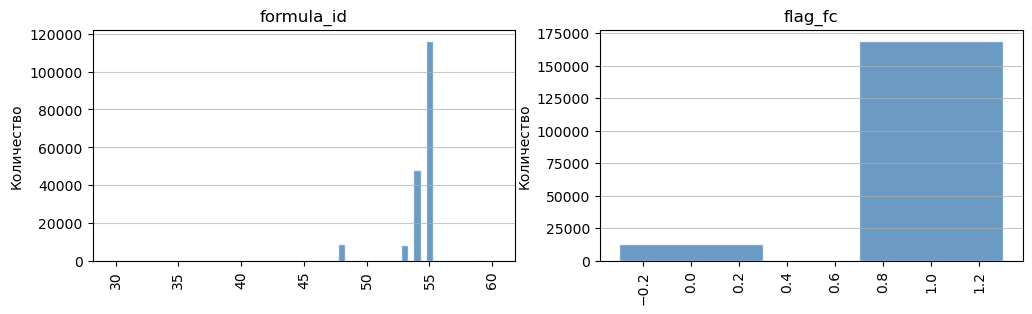

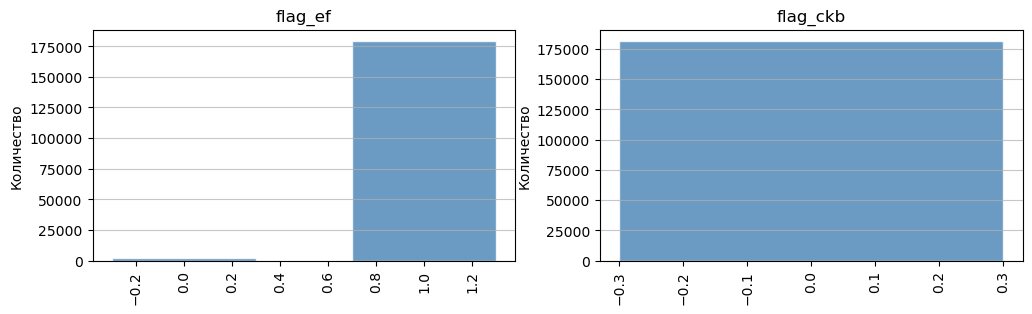

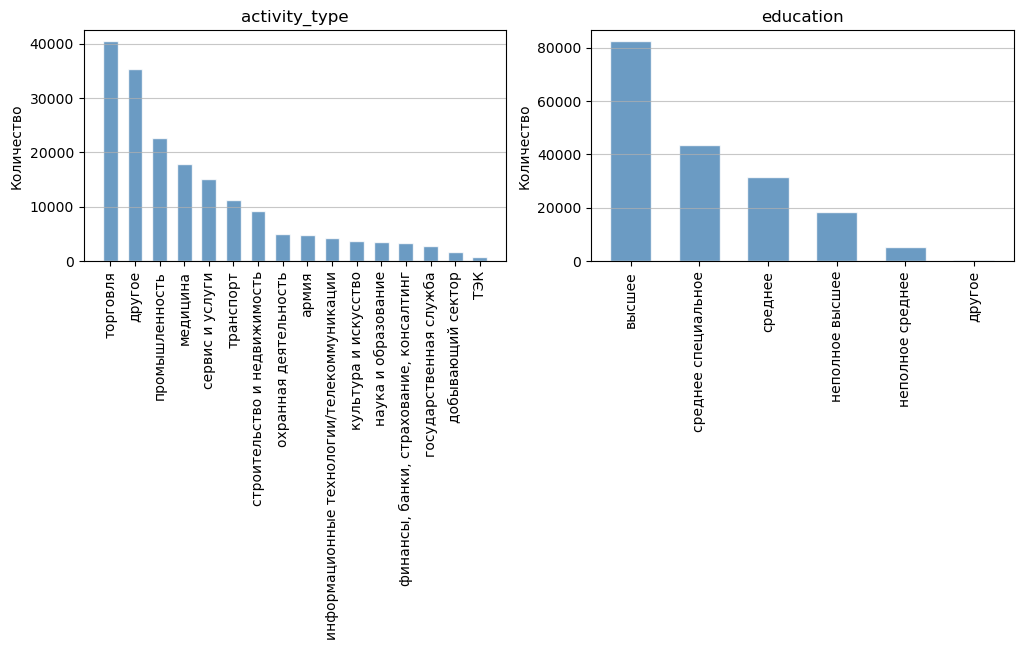

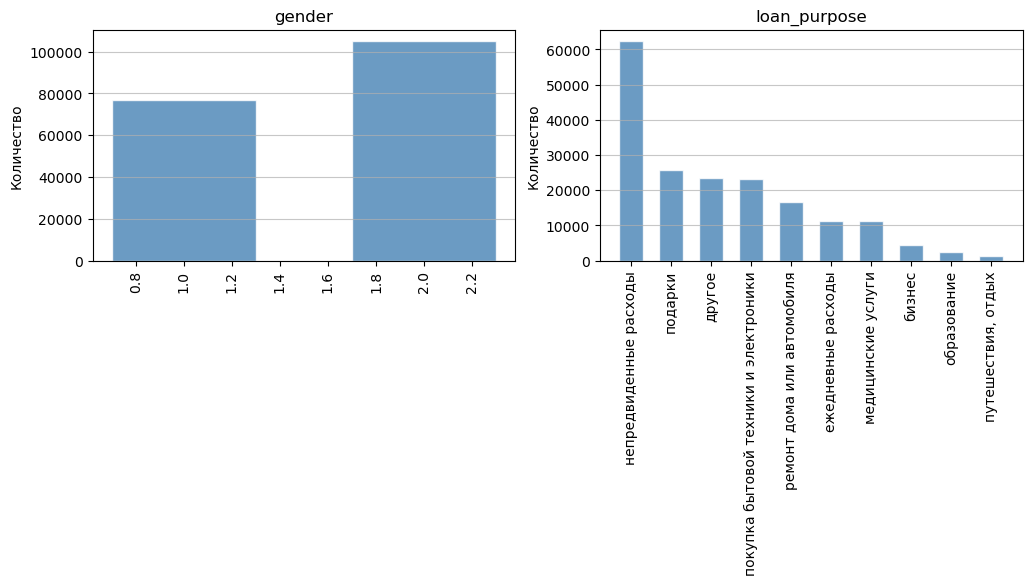

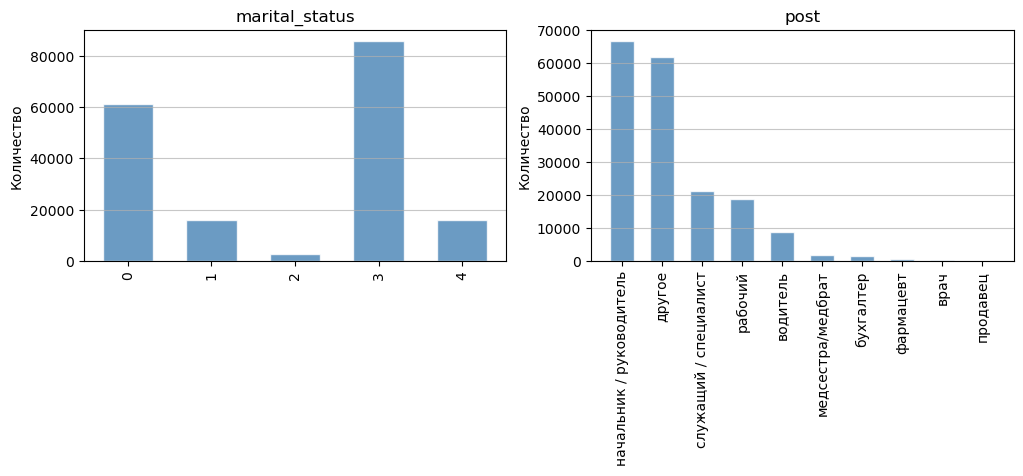

In [32]:
plt.figure(figsize=(12, 3))
cat_bar(anket, 121, cat[0])
cat_bar(anket, 122, cat[1])
plt.figure(figsize=(12, 3))
cat_bar(anket, 121, cat[2])
cat_bar(anket, 122, cat[3])
plt.figure(figsize=(12, 3))
cat_bar(anket, 121, cat[4])
cat_bar(anket, 122, cat[5])
plt.figure(figsize=(12, 3))
cat_bar(anket, 121, cat[6])
cat_bar(anket, 122, cat[7])
plt.figure(figsize=(12, 3))
cat_bar(anket, 121, cat[8])
cat_bar(anket, 122, cat[9])

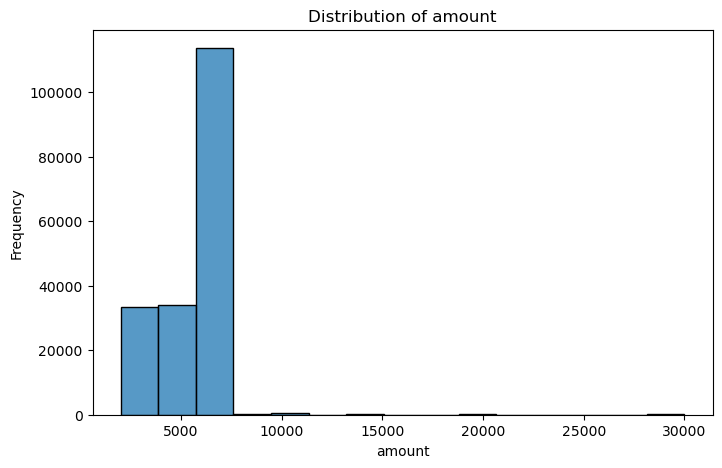

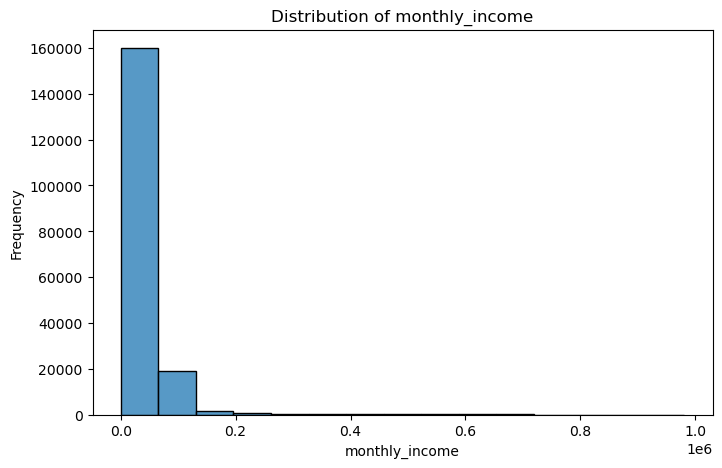

In [33]:
plot_distribution(anket, numeric, None, 15)

*график ежемесячного дохода получился не очень информативным, поэтому можно просто обратиться к начальной функции в зоне дискрайба (с этим столбцом не было никаких преобразований, поэтому он и не изменился)*

In [34]:
anket.drop(columns='unnamed_0', inplace=True)

По графикам можно увидеть, что:
- чаще всего используется модель для анализа под номером 55
- флаг наличия ответа от партнёра "один" и "два" почти всегда 1, а партнёра "три" - всегда 0
- займы берут по большей части из-за непредвиденных трат и подарков
- большая часть имеет высшее образование или хотя бы среднее специальное
- большая часть заемщиков с их же слов является категорией руководства

### payments

In [35]:
information(payments, 'PAYMENTS')

****************************** PAYMENTS ******************************



draft_id           approval_create_time  \
0  3ac9e896-80a7-4d07-af43-a3b775b30739  2021-02-14 09:22:21.985028900   
1  f76f3e80-946e-46df-9db6-795d112e63b4  2021-02-22 22:11:32.802797500   
2  187b4bf8-f41c-4a6d-8e27-dc39bc449b90     2021-04-12 15:55:27.301849   
3  6df8c019-7172-4733-bab1-51d2400e0ec5  2021-05-13 16:47:05.329747100   
4  d160dd00-075b-4e5a-a106-9704d3458261  2021-01-25 18:17:06.242752500   
5  ecdf6535-a563-4126-b81a-b075028e9646     2021-03-22 11:01:35.273895   
6  2380ec43-60f9-4579-969d-9abc08139da4  2021-02-22 18:20:06.026900900   
7  5609ee16-befe-4237-8d7c-e93a69570b2e  2021-02-01 20:12:53.384840200   
8  c5a2b4a3-3b89-4cdb-af3d-4ad134df5c75  2021-03-03 14:59:08.696058100   
9  8fd068af-8343-439c-bb6c-d35dd40ea19f     2021-04-02 07:12:38.811036   

   approval_amount  request_amount  formula_id    answer  loan_amount  \
0             6000        6,000.00       55.00     Отказ          NaN   
1             6000        6,000.00       54.00  Одобрено     6,000.00   
2             5000        5,000.00       55.00     Отказ          NaN   
3             6600        6,000.00       55.00  Одобрено     6,600.00   
4             6000        6,000.00       55.00     Отказ          NaN   
5             5000        5,000.00       55.00     Отказ          NaN   
6             4000        4,000.00       55.00     Отказ          NaN   
7             4000        4,000.00       55.00     Отказ          NaN   
8             3000        3,000.00       48.00     Отказ          NaN   
9             5000        5,000.00       55.00     Отказ          NaN   

   issue_date  duration retire_date loan_status real_retire_date   balance  \
0         NaN       NaN         NaN         NaN              NaN       NaN   
1  2021-02-24     31.00  2021-03-27     Погашен       2021-03-04      0.00   
2         NaN       NaN         NaN         NaN              NaN       NaN   
3  2021-05-13     31.00  2021-06-13   Просрочен              NaN 16,320.10   
4         NaN       NaN         NaN         NaN              NaN       NaN   
5         NaN       NaN         NaN         NaN              NaN       NaN   
6         NaN       NaN         NaN         NaN              NaN       NaN   
7         NaN       NaN         NaN         NaN              NaN       NaN   
8         NaN       NaN         NaN         NaN              NaN       NaN   
9         NaN       NaN         NaN         NaN              NaN       NaN   

   payment  day_of_delay  amount_00  amount_15  amount_30  amount_45  \
0      NaN           NaN        NaN        NaN        NaN        NaN   
1 6,480.00          0.00   6,480.00        NaN        NaN        NaN   
2      NaN           NaN        NaN        NaN        NaN        NaN   
3   179.90        361.00        NaN        NaN        NaN        NaN   
4      NaN           NaN        NaN        NaN        NaN        NaN   
5      NaN           NaN        NaN        NaN        NaN        NaN   
6      NaN           NaN        NaN        NaN        NaN        NaN   
7      NaN           NaN        NaN        NaN        NaN        NaN   
8      NaN           NaN        NaN        NaN        NaN        NaN   
9      NaN           NaN        NaN        NaN        NaN        NaN   

   amount_60  amount_90  amount_91  
0        NaN        NaN        NaN  
1        NaN        NaN        NaN  
2        NaN        NaN        NaN  
3        NaN        NaN     179.90  
4        NaN        NaN        NaN  
5        NaN        NaN        NaN  
6        NaN        NaN        NaN  
7        NaN        NaN        NaN  
8        NaN        NaN        NaN  
9        NaN        NaN        NaN

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182007 entries, 0 to 182006
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   draft_id              182007 non-null  object 
 1   approval_create_time  182007 non-null  object 
 2   approval_amount       182007 non-null  int64  
 3   request_amount        182007 non-null  float64
 4   formula_id            182007 non-null  float64
 5   answer                182007 non-null  object 
 6   loan_amount           41420 non-null   float64
 7   issue_date            41420 non-null   object 
 8   duration              41420 non-null   float64
 9   retire_date           41420 non-null   object 
 10  loan_status           41420 non-null   object 
 11  real_retire_date      28806 non-null   object 
 12  balance               41420 non-null   float64
 13  payment               41420 non-null   float64

Очень большое кол-во пропусков, и эти пропуски обусловлены по большей частью тем, что наши модели выдали отказ в кредите, следовательно дальнейших данных по ним быть не может.
На данном этапе отказные клиенты нас не интересуют, поэтому оставим датасет только с теми, кому был одобрен займ
*Далее нам понадобятся данные отказняков, чтобы проверить работоспособность скорринговых моделей, делавших отказы на этих клиентов*  
```python
payments_app = payments.loc[payments['answer']=='Одобрено']
print("Доля одобрения:", round(payments_app.shape[0] / payments.shape[0], 2))
```
После этого было обнаружено большое кол-во пропусков в столбцах 'loan_amount', 'issue_date', 'duration', 'retire_date', 'loan_status' и при том кол-во пропусков одинаковое (11390), следовательно, пропущенные значения - это клиенты, получившие одобрение, но по своему желанию не взявших кредит. От них тоже избавимся.  
- Доля одобрения показала 29%

In [36]:
payments_app = payments.dropna(subset=['loan_amount'])

Выведем общую информацию по обновленному датасету

In [37]:
information(payments_app, 'PAYMENTS_APPROVED')

****************************** PAYMENTS_APPROVED ******************************



draft_id           approval_create_time  \
1   f76f3e80-946e-46df-9db6-795d112e63b4  2021-02-22 22:11:32.802797500   
3   6df8c019-7172-4733-bab1-51d2400e0ec5  2021-05-13 16:47:05.329747100   
11  5963f5ff-3d8b-499c-aafa-7aa9a0e6a98b  2021-05-08 05:40:39.931936900   
12  0ebf262a-d27f-4d88-bae8-1e09322fb12f  2021-02-03 20:52:17.010302600   
18  adc23c19-d21b-4bb5-ad2b-6faccae5a045  2021-02-24 10:59:32.423942700   
20  58c07d52-a219-4e0e-b04b-2437b5c10046  2021-02-06 19:56:56.421314300   
29  bcdbd0a9-80d3-4c97-b467-4c39cdfa255d  2021-01-15 22:18:55.025427600   
32  92d04954-8cee-4fb2-87b6-1022a4e5ede0  2021-05-20 22:08:50.337660900   
35  76838ac6-c0bb-4baa-84bf-a9aec9370438  2021-03-30 09:13:29.655337600   
39  82fb3ea5-8514-484c-b62e-33e3d96ca080  2021-03-05 11:12:32.686488500   

    approval_amount  request_amount  formula_id    answer  loan_amount  \
1              6000        6,000.00       54.00  Одобрено     6,000.00   
3              6600        6,000.00       55.00  Одобрено     6,600.00   
11             5000        5,000.00       55.00  Одобрено     5,000.00   
12             6500        6,000.00       54.00  Одобрено     6,500.00   
18             6000        6,000.00       54.00  Одобрено     6,000.00   
20             6000        6,000.00       55.00  Одобрено     6,000.00   
29             6000        6,000.00       55.00  Одобрено     6,000.00   
32             6000        6,000.00       55.00  Одобрено     6,000.00   
35             6600        6,000.00       55.00  Одобрено     6,600.00   
39             4000        4,000.00       55.00  Одобрено     4,000.00   

    issue_date  duration retire_date loan_status real_retire_date   balance  \
1   2021-02-24     31.00  2021-03-27     Погашен       2021-03-04      0.00   
3   2021-05-13     31.00  2021-06-13   Просрочен              NaN 16,320.10   
11  2021-05-08     31.00  2021-06-08   Просрочен              NaN  3,645.18   
12  2021-02-03     31.00  2021-03-06     Погашен       2021-05-31      0.00   
18  2021-02-24     14.00  2021-03-10     Погашен       2021-03-10      0.00   
20  2021-02-06     31.00  2021-03-09     Погашен       2021-03-09      0.00   
29  2021-01-15     31.00  2021-02-15   Просрочен              NaN 12,124.42   
32  2021-05-21     31.00  2021-06-21     Погашен       2021-06-21      0.00   
35  2021-03-30     16.00  2021-04-15     Погашен       2021-04-08      0.00   
39  2021-03-05     31.00  2021-04-05     Погашен       2021-03-11      0.00   

     payment  day_of_delay  amount_00  amount_15  amount_30  amount_45  \
1   6,480.00          0.00   6,480.00        NaN        NaN        NaN   
3     179.90        361.00        NaN        NaN        NaN        NaN   
11  8,854.82        366.00        NaN        NaN        NaN        NaN   
12 14,105.00         86.00        NaN        NaN        NaN        NaN   
18  6,840.00          0.00   6,840.00        NaN        NaN        NaN   
20  7,860.00          0.00   7,860.00        NaN        NaN        NaN   
29  2,875.58        479.00        NaN        NaN        NaN        NaN   
32  7,860.00          0.00   7,860.00        NaN        NaN        NaN   
35  7,194.00          0.00   7,194.00        NaN        NaN        NaN   
39  4,240.00          0.00   4,240.00        NaN        NaN        NaN   

    amount_60  amount_90  amount_91  
1         NaN        NaN        NaN  
3         NaN        NaN     179.90  
11        NaN        NaN   8,854.82  
12        NaN  14,105.00        NaN  
18        NaN        NaN        NaN  
20        NaN        NaN        NaN  
29        NaN        NaN   2,875.58  
32        NaN        NaN        NaN  
35        NaN        NaN        NaN  
39        NaN        NaN        NaN

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41420 entries, 1 to 182006
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   draft_id              41420 non-null  object 
 1   approval_create_time  41420 non-null  object 
 2   approval_amount       41420 non-null  int64  
 3   request_amount        41420 non-null  float64
 4   formula_id            41420 non-null  float64
 5   answer                41420 non-null  object 
 6   loan_amount           41420 non-null  float64
 7   issue_date            41420 non-null  object 
 8   duration              41420 non-null  float64
 9   retire_date           41420 non-null  object 
 10  loan_status           41420 non-null  object 
 11  real_retire_date      28806 non-null  object 
 12  balance               41420 non-null  float64
 13  payment               41420 non-null  float64
 14  day_of_dela

в столбце real_retire_date у нас большое кол-во пропусков (12614). Гипотетически, эти пропуски для тех клиентов, кто просрочил свой кредит. Проверим это

In [38]:
payments_app.loc[payments_app['loan_status']=='Просрочен']['loan_status'].count()

12614

Те, кто пимеют статус кредита "просрочен", для нас уже имеет дефолтность, а у тех, у кого кредит погашен - надо смотреть, так как некоторые гасили займы и на 90-ый день, что для нас по условию уже идёт как дефолт. Распознать мы их можем по столбцам 'amount_45', 'amount_60', 'amount_90', 'amount_91'. Если клиент закрыл свой долг после 30-го дня, то один из этих столбцов будет содержать число помимо Nan.

**Добавим столбец дефолт со значениями: 1 - дефолтнулся, 0 - не дефолтнулся**

In [39]:
# Внесли целевую переменную
payments_app['default'] = 1

# Там, где статус займа - погашен и при этом погашение было просрочено не больше 30 дней поставили "не дефолтнулся"
payments_app.loc[(payments_app["loan_status"] == "Погашен") & 
                 (payments_app["amount_45"].isnull()) &
                 (payments_app["amount_60"].isnull()) &
                 (payments_app["amount_90"].isnull()) &
                 (payments_app["amount_91"].isnull()), "default"] = 0


In [40]:
# Приведём столбцы с датами к нужному виду
payments_app['approval_create_time'] = pd.to_datetime(payments_app['approval_create_time'], format='%Y-%m-%d').dt.floor('d')
payments_app['issue_date'] = pd.to_datetime(payments_app['issue_date'], format='%Y-%m-%d').dt.floor('d')
payments_app['retire_date'] = pd.to_datetime(payments_app['retire_date'], format='%Y-%m-%d').dt.floor('d')
payments_app['real_retire_date'] = pd.to_datetime(payments_app['real_retire_date'], format='%Y-%m-%d').dt.floor('d')

In [41]:
# Создадим новый столбец, который покажет, сколько дней прошло с момента подачи заявки и на момент выдачи займа
payments_app['time_to_receipt'] = (payments_app['issue_date'] - payments_app['approval_create_time']).dt.days

# Посмотрим на дискрайб, чтобы оценить результат
payments_app['time_to_receipt'].describe()

count    41,420.00
mean         -0.56
std         175.38
min     -35,000.00
25%           0.00
50%           0.00
75%           0.00
max       7,000.00
Name: time_to_receipt, dtype: float64

In [42]:
# Кол-во выбросов
payments_app.loc[(payments_app['time_to_receipt'] < 0) | (payments_app['time_to_receipt'] > 1000)]['time_to_receipt'].count()

2

In [43]:
# Удалим выбросы
payments_app.drop(
    payments_app[(payments_app['time_to_receipt'] < 0) | (payments_app['time_to_receipt'] > 1000)].index, inplace=True
)

In [44]:
payments_app['time_to_receipt'].describe()

count   41,418.00
mean         0.11
std          0.41
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          3.00
Name: time_to_receipt, dtype: float64

Одобрение занимаем от 0 до 3х дней

In [45]:
# Удалим столбцы, которые нам больше не понадобятся
payments_app = payments_app.drop(
                            columns=
                                [
                                    'approval_create_time', 'issue_date', 'retire_date', 
                                    'real_retire_date', 'amount_00', 'amount_15', 'amount_30', 
                                    'amount_45', 'amount_60', 'amount_90', 'amount_91', 
                                    'answer', 'loan_status'
                                ]
                            )

In [46]:
# Выберем категориальные столбцы
cat = ['formula_id', 'default']
numeric = list(payments_app.select_dtypes(include=['int64', 'float64']).columns)

In [47]:
# Переведём категориальные столбцы в надлежащий тип
payments_app[cat] = payments_app[cat].astype('category')

```python
payments_app['time_delay'] = (payments_app['real_retire_date'] - payments_app['retire_date']).dt.days
```
Проверили, что кол-во дней просрочки совпадает по уже данному столбцу на всякий случай

**Построим графики, чтобы посмотреть на распределения**

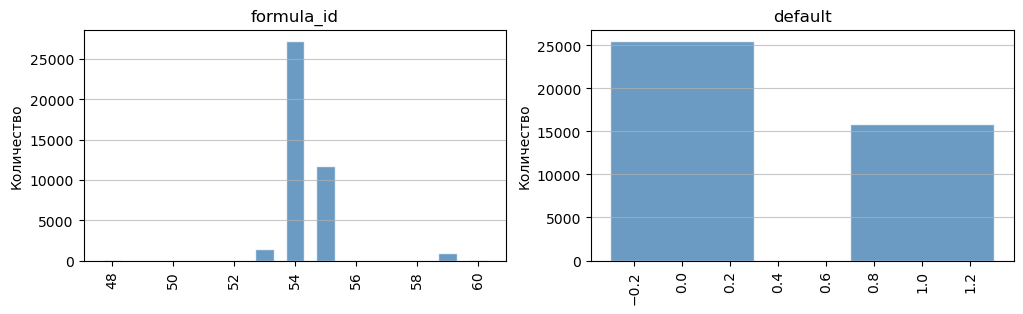

In [48]:
plt.figure(figsize=(12, 3))
cat_bar(payments_app, 121, cat[0])
cat_bar(payments_app, 122, cat[1])

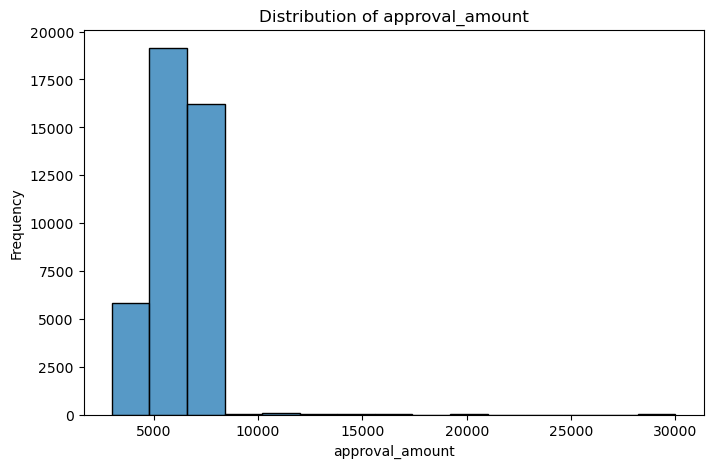

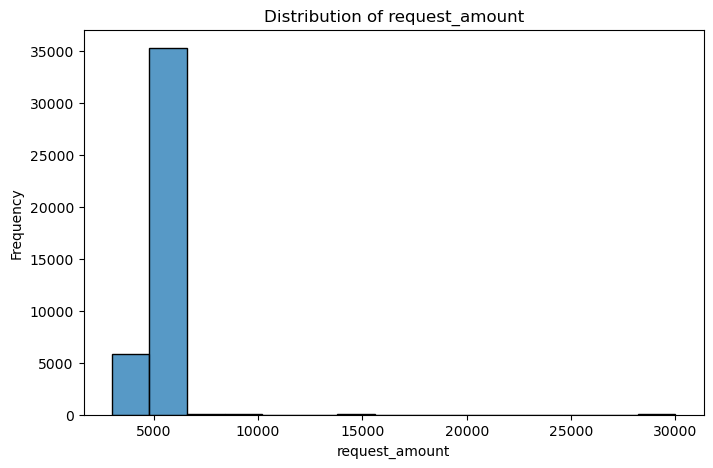

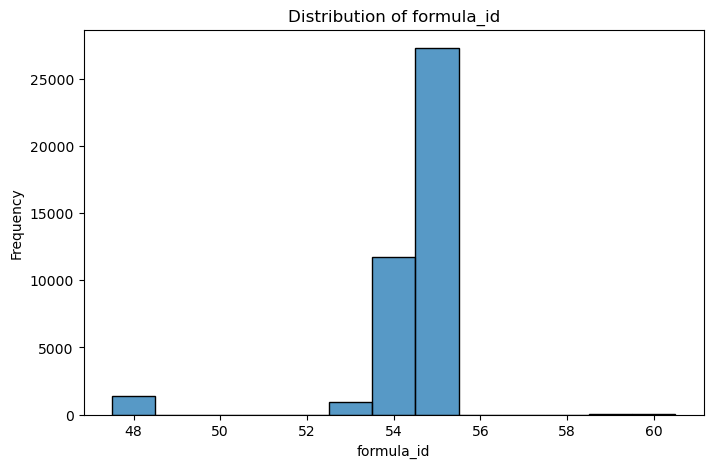

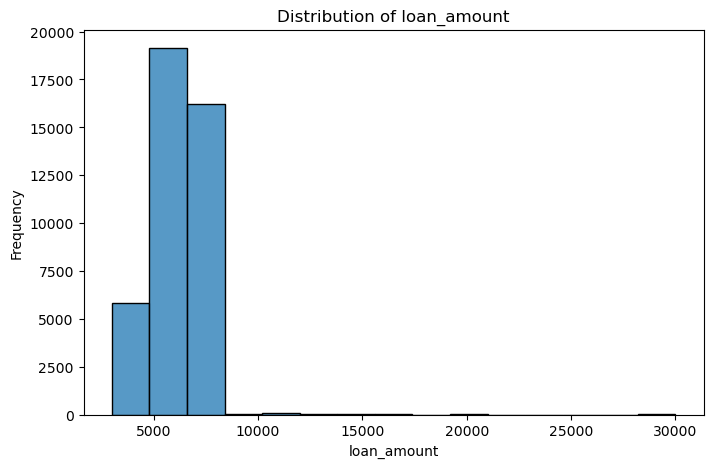

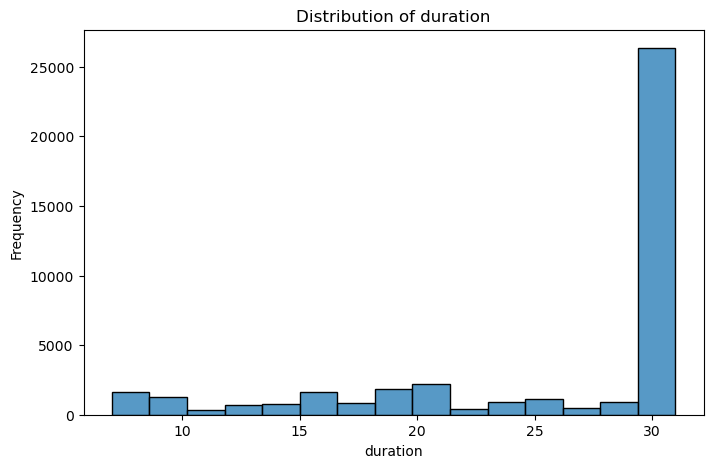

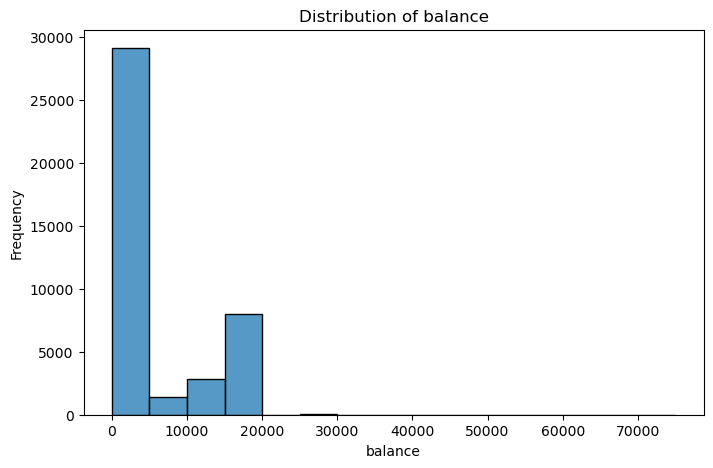

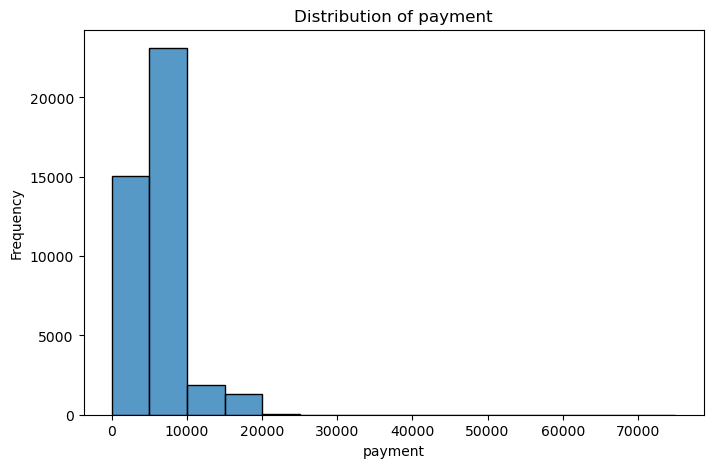

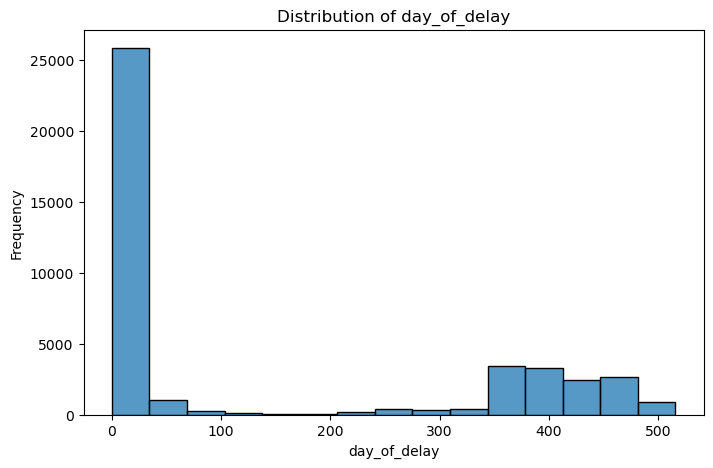

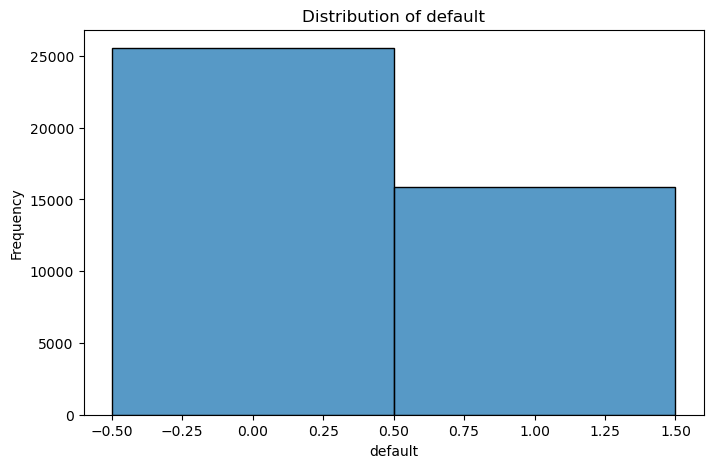

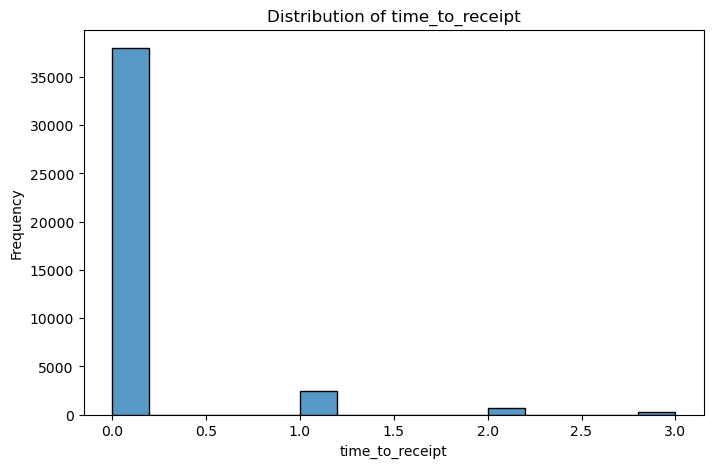

In [49]:
plot_distribution(payments_app, numeric, None, 15)

В целом следует сказать, что надо будет объединять этот датафрейм с датафреймом анкеты методом инер, чтобы продолжить исследовательский анализ данных на интересующих нас вещах.
Была проведена работа по пропущенным значениям, генерации новых столбцов, работе с типом данных и удалению выбросов.
Так же были составлены графики для общего ознакомления.
Был составлен будущий целевой признак, где наблюдается дисбаланс классов.

### ml

In [50]:
information(ml, 'PAYMENTS_APPROVED')

****************************** PAYMENTS_APPROVED ******************************



draft_id  cntcardusersall_mean  \
0  3ac9e896-80a7-4d07-af43-a3b775b30739                  1.00   
1  f76f3e80-946e-46df-9db6-795d112e63b4                  3.00   
2  187b4bf8-f41c-4a6d-8e27-dc39bc449b90                  1.00   
3  6df8c019-7172-4733-bab1-51d2400e0ec5                 13.00   
4  d160dd00-075b-4e5a-a106-9704d3458261                  2.00   
5  ecdf6535-a563-4126-b81a-b075028e9646                  3.00   
6  2380ec43-60f9-4579-969d-9abc08139da4                  1.00   
7  5609ee16-befe-4237-8d7c-e93a69570b2e                  1.00   
8  c5a2b4a3-3b89-4cdb-af3d-4ad134df5c75                   NaN   
9  8fd068af-8343-439c-bb6c-d35dd40ea19f                  3.00   

   count_issued_for_90_days_sum  f_iss_amnt  count_issued_for_30_daysall_sum  \
0                          0.00         NaN                             0.00   
1                         11.00        0.54                            11.00   
2                          2.00        0.00                             1.00   
3                         10.00        0.84                             4.00   
4                          1.00        0.00                             1.00   
5                           NaN         NaN                             0.00   
6                           NaN         NaN                             0.00   
7                           NaN         NaN                             0.00   
8                           NaN         NaN                              NaN   
9                          0.00        0.80                             0.00   

   count_issued_for_90_daysall_sum  fin_karta_score_v_3_rateall_mean  \
0                             0.00                              0.11   
1                            11.00                              0.81   
2                             2.00                              0.29   
3                            10.00                              0.80   
4                             1.00                              0.29   
5                             0.00                              0.00   
6                             0.00                              0.00   
7                             0.00                              0.00   
8                              NaN                               NaN   
9                             0.00                              1.00   

   fin_karta_score_v_1_rateall_sum  fin_karta_score_v_2_rate  \
0                             0.00                      0.00   
1                             0.02                      0.32   
2                             0.00                      0.03   
3                              NaN                      0.47   
4                             0.00                      0.03   
5                             0.00                      0.00   
6                             0.00                      0.00   
7                             0.00                      0.00   
8                              NaN                       NaN   
9                             0.00                      0.04   

   fin_karta_score_v_2_rateall_sum  first_transfer_from_mfo_dateall_sum  \
0                             0.00                                 0.00   
1                             0.32                                17.51   
2                             0.03                                31.68   
3                             0.47                               353.71   
4                             0.03                                 6.78   
5                             0.00                                 0.00   
6                             0.00                                 0.00   
7                             0.00                                 0.00   
8                              NaN                                  NaN   
9                             0.04                               663.30   

   last_successful_discharge_date_1_sum  \
0                                   NaN   
1                       

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182007 entries, 0 to 182006
Columns: 151 entries, draft_id to ipb
dtypes: float64(150), object(1)
memory usage: 209.7+ MB
None

---------- NAN ----------

draft_id                                       0
cntcardusersall_mean                       12596
count_issued_for_90_days_sum               35534
f_iss_amnt                                 95296
count_issued_for_30_daysall_sum            12554
count_issued_for_90_daysall_sum            12554
fin_karta_score_v_3_rateall_mean           12513
fin_karta_score_v_1_rateall_sum            53413
fin_karta_score_v_2_rate                   12513
fin_karta_score_v_2_rateall_sum            12513
first_transfer_from_mfo_dateall_sum        11470
last_successful_discharge_date_1_sum      114261
last_successful_discharge_dateall_mean    114261
last_discharge_amountall_sum               12554
num_cellph_sp_30all_mean                   12300
nu

Датафрейм очень объемный и так же он содержит огромное кол-во пропусков. У нас нет ни описания столбцов, ни информации о природе этих пропусков, значит, их придётся удалять, но стараться удалять с наименьшими потерями по информации. Посмотрим на кол-во столбцов с высокой корреляцией Пирсона, если таких окажется много, то примем решение просто удалять столбцы с высоким кол-вом пропусков.

In [51]:
threshold = 0.8

# создаем пустой датафрейм для сохранения результатов
corr_df = pd.DataFrame(columns=['column_1', 'column_2', 'correlation'])

# получаем матрицу корреляций
corr_matrix = ml.corr()

# перебираем все пары столбцов в матрице корреляций
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # если значение корреляции больше заданного порога
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # сохраняем в датафрейм названия столбцов и значение корреляции
            corr_df = corr_df.append({'column_1': corr_matrix.columns[i], 
                                      'column_2': corr_matrix.columns[j], 
                                      'correlation': corr_matrix.iloc[i, j]}, 
                                     ignore_index=True)

# сортируем датафрейм по убыванию абсолютного значения корреляции
corr_df = corr_df.reindex(corr_df['correlation'].abs().sort_values(ascending=False).index)

# выводим результаты
print(corr_df)

                                  column_1  \
13                            cred_activ_3   
3          fin_karta_score_v_2_rateall_sum   
4   last_successful_discharge_dateall_mean   
1          count_issued_for_90_daysall_sum   
7                             cred_activ_1   
62                   v_6_all_micro_1y_mean   
26                 cred_sum_all_all_1y_sum   
61                   v_0_all_micro_all_sum   
16             cred_annuity_all_all_1m_sum   
48                                  n_cr_3   
43                                  n_cr_2   
25            cred_sum_active_micro_1m_min   
40                                  n_cr_1   
52                           p_cls_mfo_365   
10                            cred_activ_2   
15                            cred_activ_3   
51                                  n_cr_3   
21                            cred_repay_3   
11                            cred_activ_2   
9                             cred_activ_2   
47                                

Удалим столбцы с высокими коррелляциями

In [52]:
ml = ml.drop(columns=list(corr_df['column_1']))

Удалим столбцы, где содержатся числа 90 или 180. Предположительно эти числа говорят о кол-ве дней, а у нас идёт исследование в пределах 30 дней.

In [53]:
ml = ml.filter(regex=re.compile('^(?!.*90|.*180).*$'))

Удалим столбцы, где пропусков больше 30%

In [54]:
threshold = ml.shape[0]*0.3
ml = ml.dropna(axis=1, thresh=ml.shape[0]-threshold)

Из 151 столбца у нас осталось 70  
Природа пропусков у нас всё еще неизвестна, удалять строки мы не можем, так как это приведёт к потере и так малого кол-ва строк при объединении, поэтому заполним пропуски методом ```ffill```

In [55]:
ml = ml.ffill()

Больше ничего толкового с этим датасетом мы сделать не сможем

**Минивывод**  

В датасете anket:
1. столбцы были приведены в змеиный регистр
2. в пропусках с категориальными значениями заменили пропуски на нули
3. поработали с неявными дублями и объединили некоторые категории
4. построили графики, чтобы посмотреть распределения:  
    - чаще всего используется модель для анализа под номером 55
    - флаг наличия ответа от партнёра "один" и "два" почти всегда 1, а партнёра "три" - всегда 0
    - займы берут по большей части из-за непредвиденных трат и подарков
    - большая часть имеет высшее образование или хотя бы среднее специальное
    - большая часть заемщиков с их же слов является категорией руководства
    
В датасете payments:
1. убрали клиентов, кому было отказано в займе
2. убрали клиентов, кто по своей воле не взял займ после одобрения
3. определили природу оставшихся пропусков
4. поработали с выбросами
5. убрали лишние столбцы
6. построили графики и посмотрели распределения

В датасете ml:
1. было решено бороться с пропусками удалением столбцов там, где пропусков больше 30%
2. столбцы с высокой корреляцией так же были удалены
3. столбцы, включающие в себя 90 дней и 180 дней были удалены как неинформативные в нашем случае
4. оставшиеся пропуски были заполнены методом ffill


## Исследовательский анализ данных

### Соединим наши таблицы по айди

In [56]:
df = pd.merge(anket, payments_app, on='draft_id', how='inner')

In [57]:
df.sample(4)

draft_id formula_id_x flag_fc flag_ef  \
24812  7b647651-5343-4c67-b048-ecd8312ba8c8           55       1       1   
41194  9c546c6d-671f-4849-834c-228b5253d618           55       1       1   
16285  83551f9f-5908-4f64-81e7-a6a16b89211e           55       1       1   
954    542c1525-34cd-4724-96fd-b2185a208c46           55       1       1   

      flag_ckb   amount   activity_type            education gender  \
24812        0 6,600.00  промышленность               высшее      1   
41194        0 3,500.00          другое  среднее специальное      2   
16285        0 3,600.00       транспорт      неполное высшее      2   
954          0 6,600.00  промышленность      неполное высшее      2   

                     loan_purpose marital_status  monthly_income  \
24812  ремонт дома или автомобиля              1       65,000.00   
41194  ремонт дома или автомобиля              0       29,000.00   
16285          медицинские услуги              2       35,000.00   
954        непредвиденные расходы              0       35,000.00   

                           post  approval_amount  request_amount formula_id_y  \
24812  начальник / руководитель             6600        6,000.00        55.00   
41194                    другое             3500        3,000.00        55.00   
16285     служащий / специалист             3600        3,000.00        55.00   
954                     рабочий             6600        6,000.00        55.00   

       loan_amount  duration  balance  payment  day_of_delay default  \
24812     6,600.00     31.00     0.00 8,646.00          0.00       0   
41194     3,500.00     21.00     0.00 3,780.00          0.00       0   
16285     3,600.00      7.00     0.00 3,780.00          0.00       0   
954       6,600.00     31.00     0.00 8,910.00          4.00       0   

       time_to_receipt  
24812                0  
41194                0  
16285                0  
954                  0

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41351 entries, 0 to 41350
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   draft_id         41351 non-null  object  
 1   formula_id_x     41351 non-null  category
 2   flag_fc          41351 non-null  category
 3   flag_ef          41351 non-null  category
 4   flag_ckb         41351 non-null  category
 5   amount           41351 non-null  float64 
 6   activity_type    41351 non-null  category
 7   education        41351 non-null  category
 8   gender           41351 non-null  category
 9   loan_purpose     41351 non-null  category
 10  marital_status   41351 non-null  category
 11  monthly_income   41351 non-null  float64 
 12  post             41351 non-null  category
 13  approval_amount  41351 non-null  int64   
 14  request_amount   41351 non-null  float64 
 15  formula_id_y     41351 non-null  category
 16  loan_amount      41351 non-null  float64

Удалим копию столбца

In [59]:
df.drop(columns='formula_id_y', inplace=True)

In [60]:
# Список числовых и категориальных столбцов

numeric = [col for col in df.columns if df[col].dtype == 'float' or df[col].dtype == 'int']
cat = [col for col in df.columns if df[col].dtype == 'category']

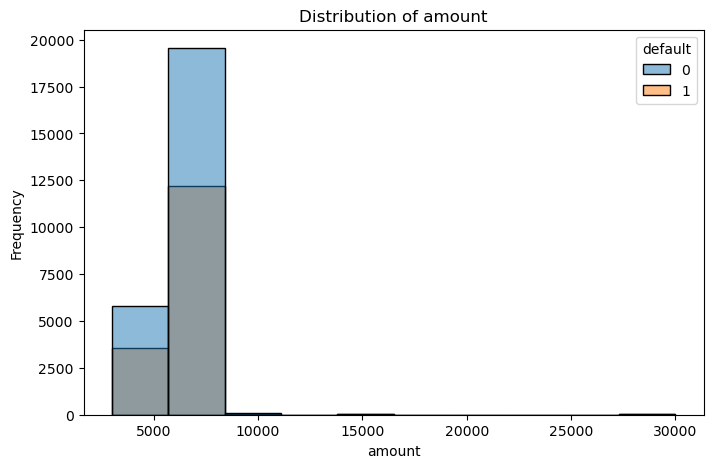

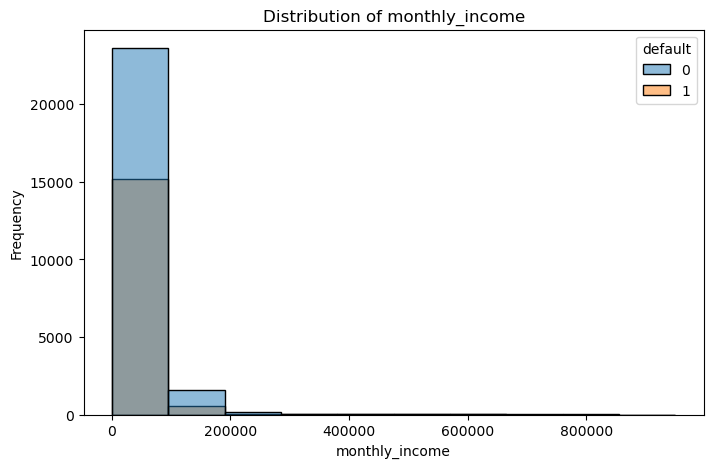

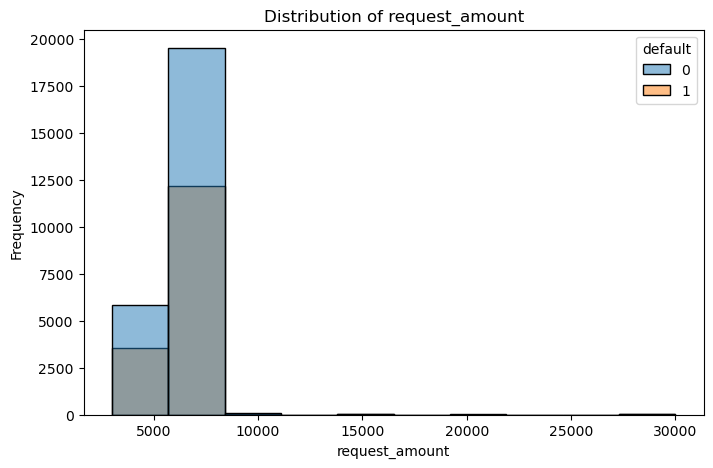

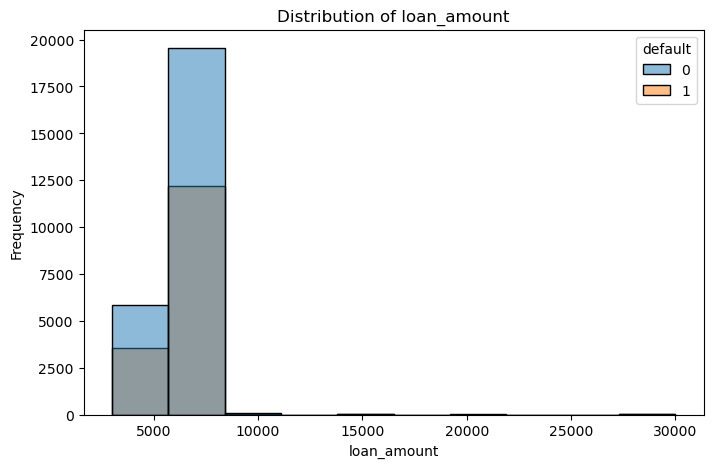

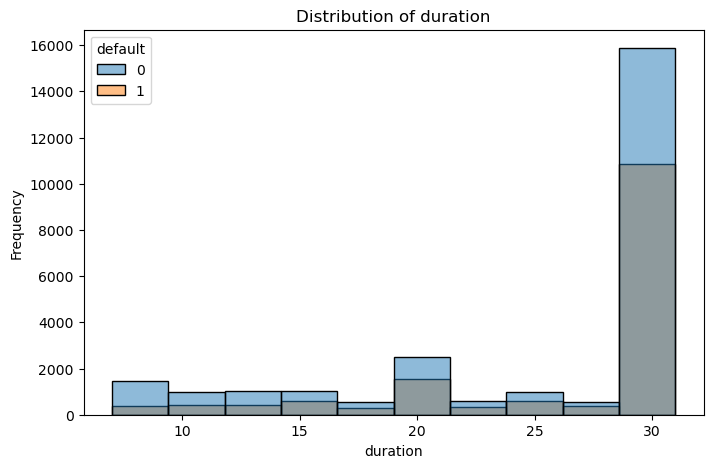

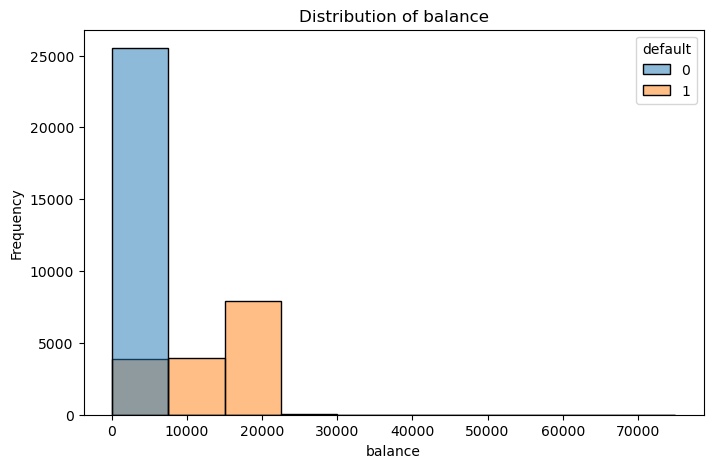

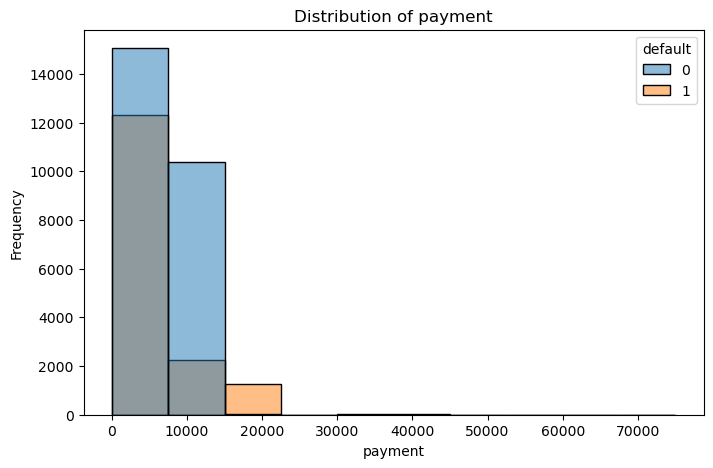

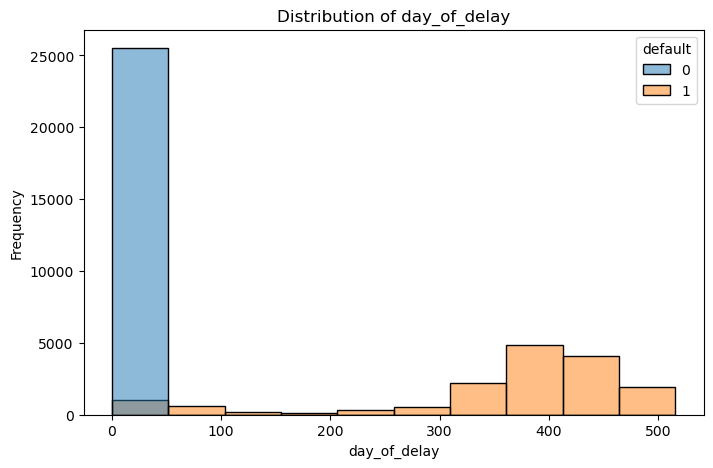

In [61]:
plot_distribution(df, numeric, 'default', 10)

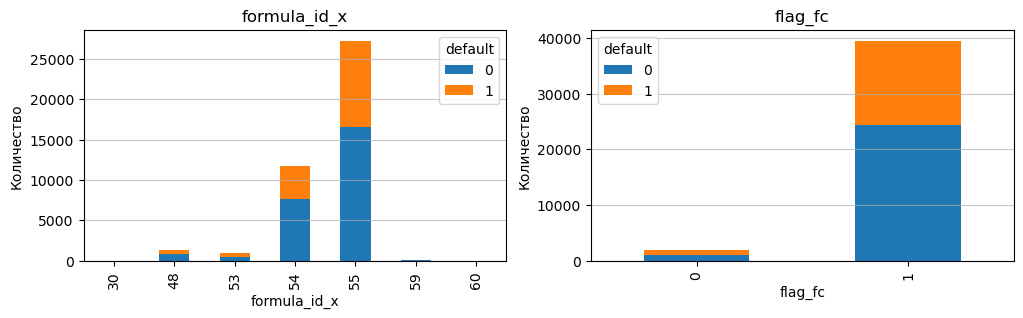

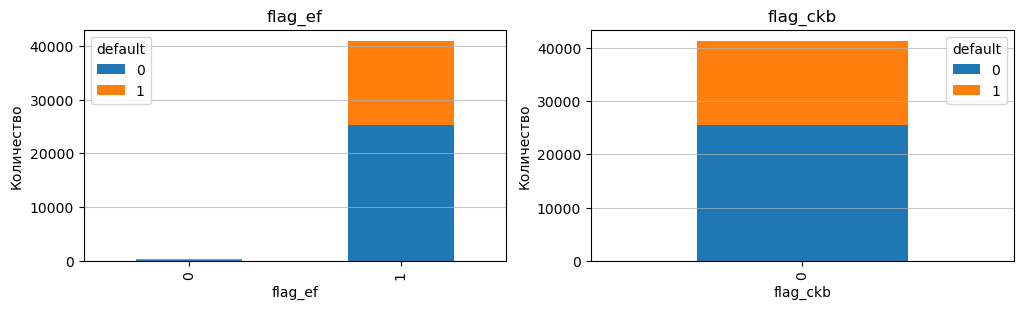

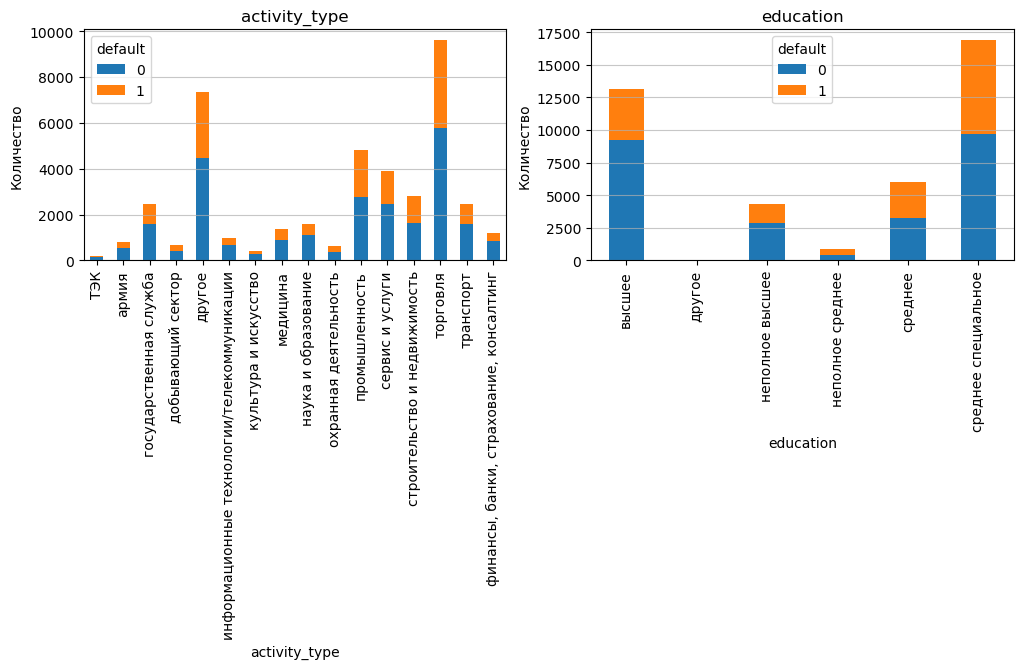

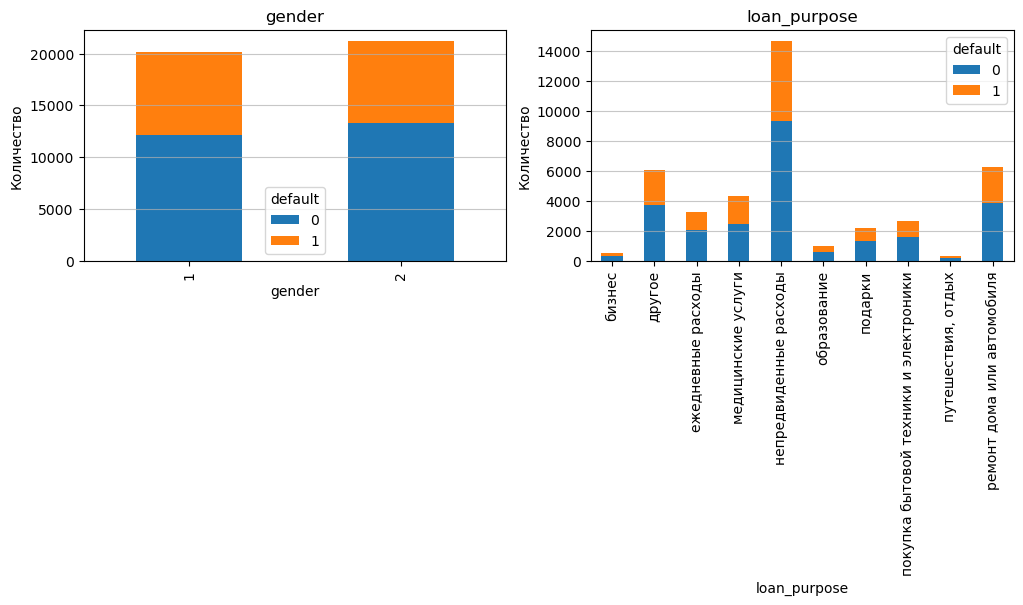

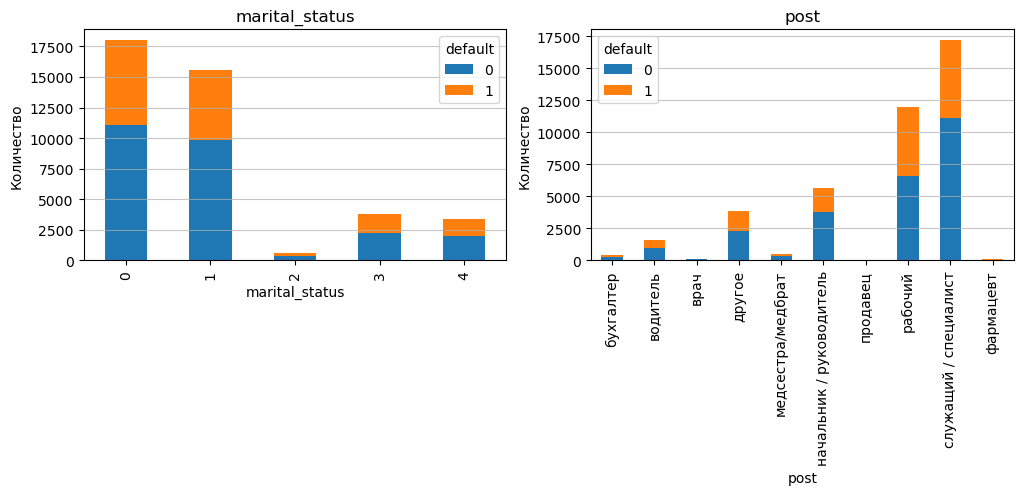

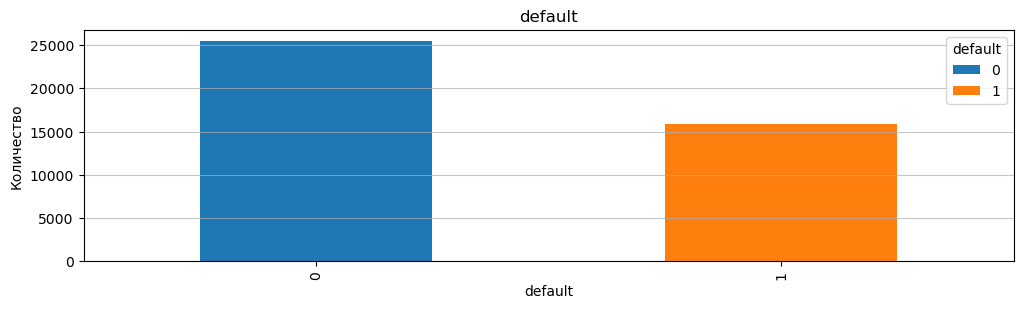

In [62]:
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[0], 'default')
cat_bar(df, 122, cat[1], 'default')
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[2], 'default')
cat_bar(df, 122, cat[3], 'default')
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[4], 'default')
cat_bar(df, 122, cat[5], 'default')
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[6], 'default')
cat_bar(df, 122, cat[7], 'default')
plt.figure(figsize=(12, 3))
cat_bar(df, 121, cat[8], 'default')
cat_bar(df, 122, cat[9], 'default')
plt.figure(figsize=(12, 3))
cat_bar(df, 111, cat[10], 'default')

In [63]:
# Сделаем сводные таблицы, чтобы посмотреть на отношения кол-ва дефолта к недефолту по каждому категориальному столбцу

for col in cat[:-1]:
    table = pd.pivot_table(df, index='default', values='draft_id', columns=col, aggfunc='count')
    table.loc['ratio'] = [table.loc[1, col] / table.loc[0, col] for col in table.columns]
    display(table)

formula_id_x   30     48     53       54        55    59   60
default                                                      
0            0.00 830.00 425.00 7,623.00 16,575.00 62.00 4.00
1            0.00 549.00 526.00 4,101.00 10,639.00 13.00 4.00
ratio         NaN   0.66   1.24     0.54      0.64  0.21 1.00

flag_fc        0         1
default                   
0       1,113.00 24,406.00
1         763.00 15,069.00
ratio       0.69      0.62

flag_ef      0         1
default                 
0       191.00 25,328.00
1       176.00 15,656.00
ratio     0.92      0.62

flag_ckb         0
default           
0        25,519.00
1        15,832.00
ratio         0.62

activity_type    ТЭК  армия  государственная служба  добывающий сектор  \
default                                                                  
0             146.00 530.00                1,605.00             396.00   
1              59.00 291.00                  862.00             297.00   
ratio           0.40   0.55                    0.54               0.75   

activity_type   другое  информационные технологии/телекоммуникации  \
default                                                              
0             4,462.00                                      669.00   
1             2,906.00                                      301.00   
ratio             0.65                                        0.45   

activity_type  культура и искусство  медицина  наука и образование  \
default                                                              
0                            283.00    914.00             1,097.00   
1                            151.00    456.00               497.00   
ratio                          0.53      0.50                 0.45   

activity_type  охранная деятельность  промышленность  сервис и услуги  \
default                                                                 
0                             351.00        2,760.00         2,459.00   
1                             266.00        2,060.00         1,450.00   
ratio                           0.76            0.75             0.59   

activity_type  строительство и недвижимость  торговля  транспорт  \
default                                                            
0                                  1,623.00  5,779.00   1,576.00   
1                                  1,183.00  3,820.00     898.00   
ratio                                  0.73      0.66       0.57   

activity_type  финансы, банки, страхование, консалтинг  
default                                                 
0                                               869.00  
1                                               335.00  
ratio                                             0.39

education   высшее  другое  неполное высшее  неполное среднее  среднее  \
default                                                                  
0         9,203.00   38.00         2,854.00            446.00 3,267.00   
1         3,967.00   30.00         1,512.00            412.00 2,748.00   
ratio         0.43    0.79             0.53              0.92     0.84   

education  среднее специальное  
default                         
0                     9,711.00  
1                     7,163.00  
ratio                     0.74

gender          1         2
default                    
0       12,175.00 13,344.00
1        7,944.00  7,888.00
ratio        0.65      0.59

loan_purpose  бизнес   другое  ежедневные расходы  медицинские услуги  \
default                                                                 
0             332.00 3,706.00            2,065.00            2,485.00   
1             196.00 2,344.00            1,230.00            1,869.00   
ratio           0.59     0.63                0.60                0.75   

loan_purpose  непредвиденные расходы  образование  подарки  \
default                                                      
0                           9,329.00       616.00 1,344.00   
1                           5,370.00       354.00   858.00   
ratio                           0.58         0.57     0.64   

loan_purpose  покупка бытовой техники и электроники  путешествия, отдых  \
default                                                                   
0                                          1,569.00              220.00   
1                                          1,099.00              120.00   
ratio                                          0.70                0.55   

loan_purpose  ремонт дома или автомобиля  
default                                   
0                               3,853.00  
1                               2,392.00  
ratio                               0.62

marital_status         0        1      2        3        4
default                                                   
0              11,060.00 9,878.00 337.00 2,262.00 1,982.00
1               6,939.00 5,666.00 265.00 1,569.00 1,393.00
ratio               0.63     0.57   0.79     0.69     0.70

post     бухгалтер  водитель  врач   другое  медсестра/медбрат  \
default                                                          
0           227.00    969.00 84.00 2,301.00             331.00   
1           156.00    656.00 49.00 1,528.00             147.00   
ratio         0.69      0.68  0.58     0.66               0.44   

post     начальник / руководитель  продавец  рабочий  служащий / специалист  \
default                                                                       
0                        3,790.00      3.00 6,612.00              11,150.00   
1                        1,896.00      1.00 5,342.00               6,028.00   
ratio                        0.50      0.33     0.81                   0.54   

post     фармацевт  
default             
0            52.00  
1            29.00  
ratio         0.56

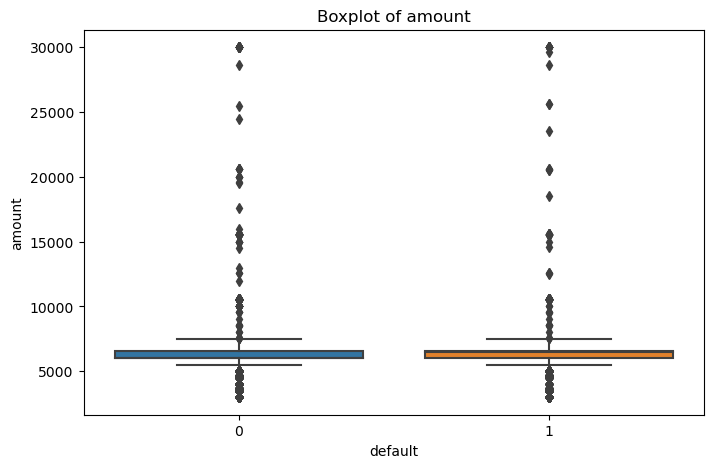

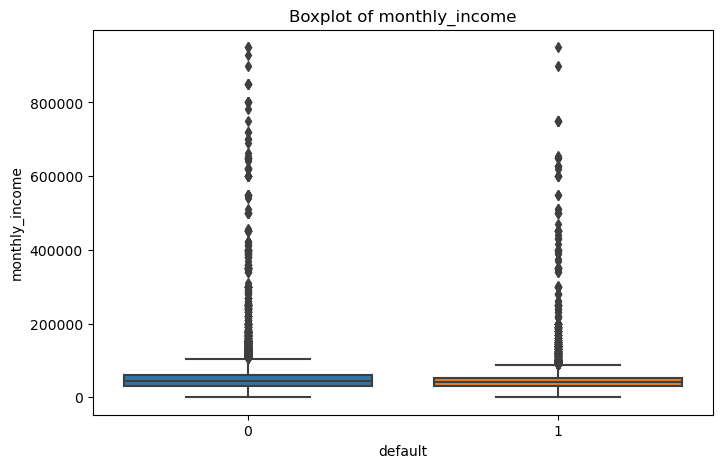

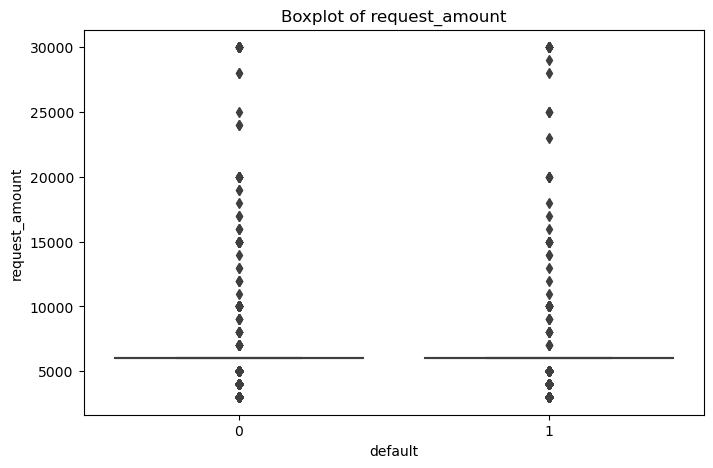

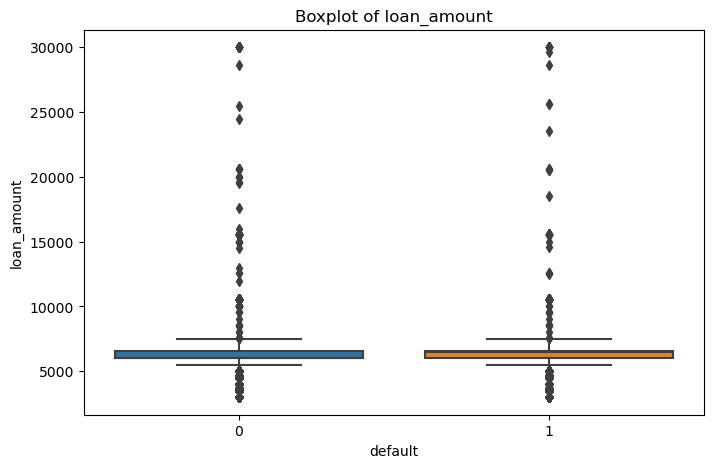

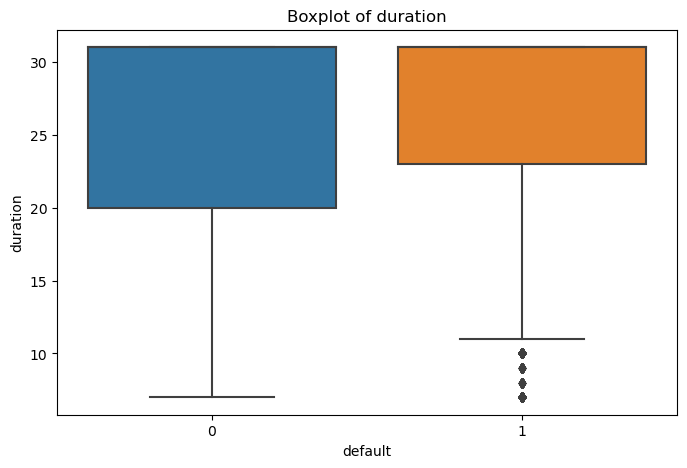

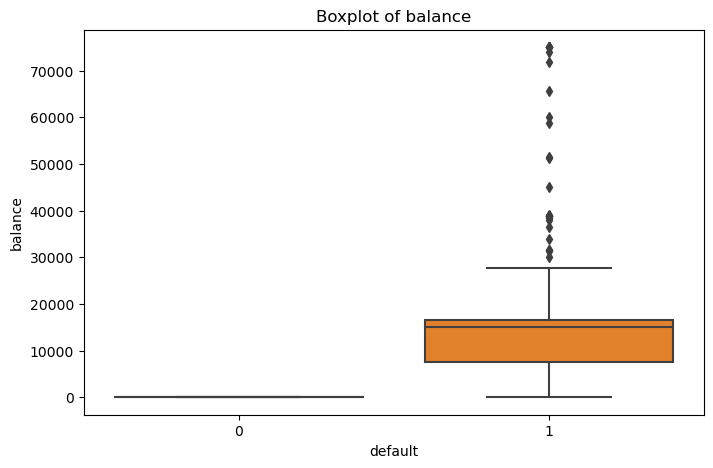

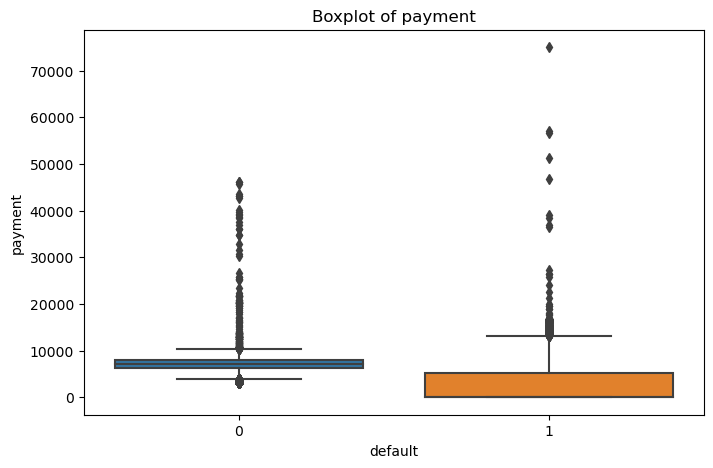

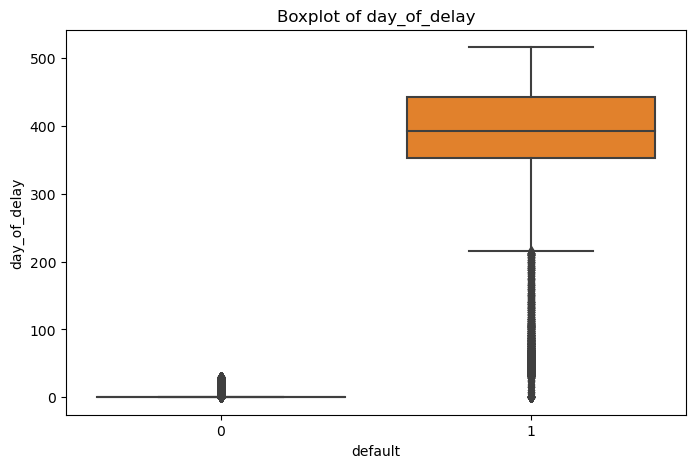

In [64]:
plot_boxplot(df, numeric, 'default')

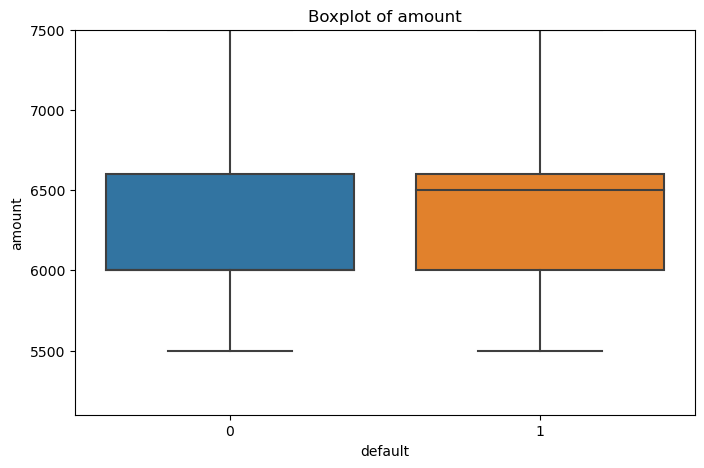

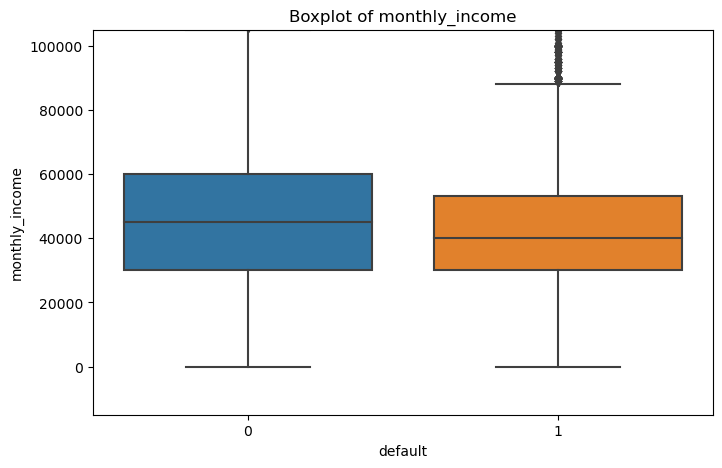

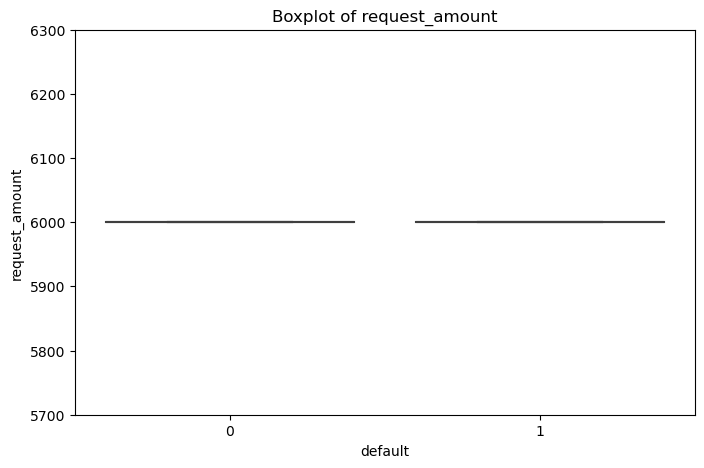

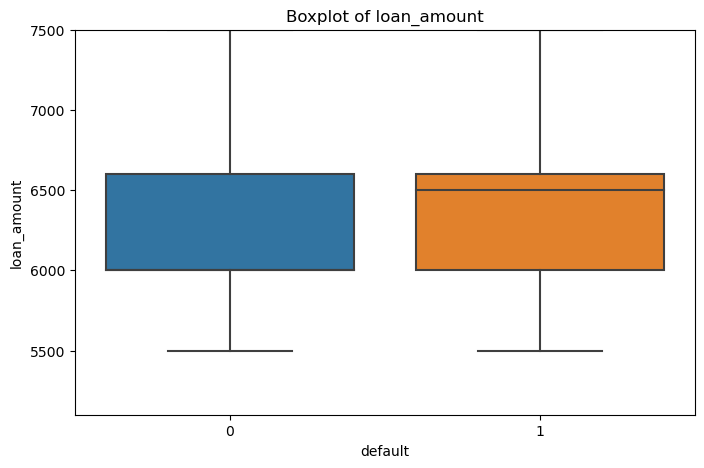

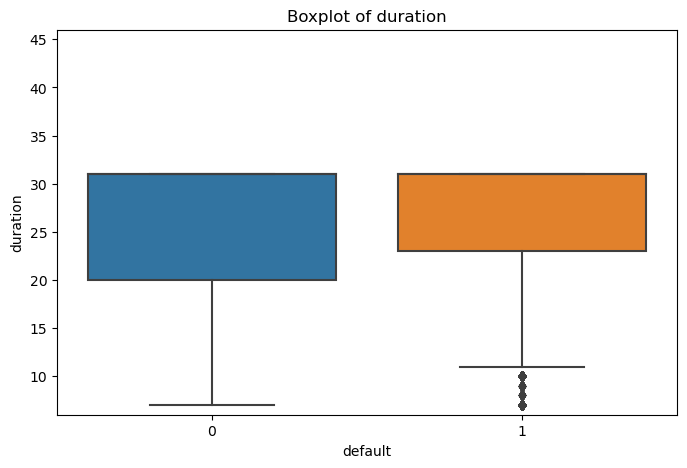

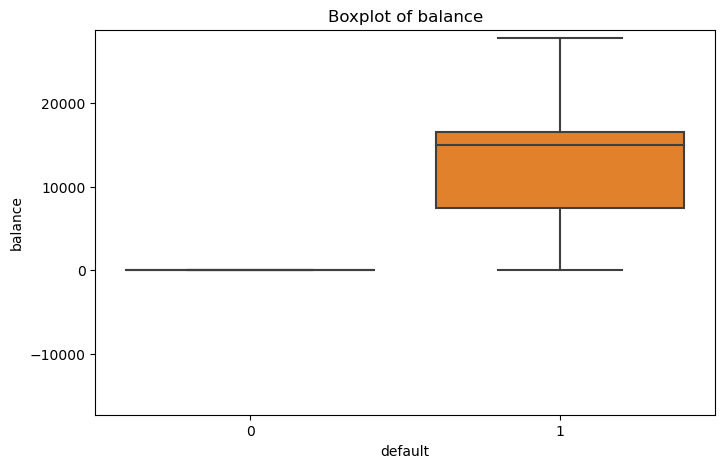

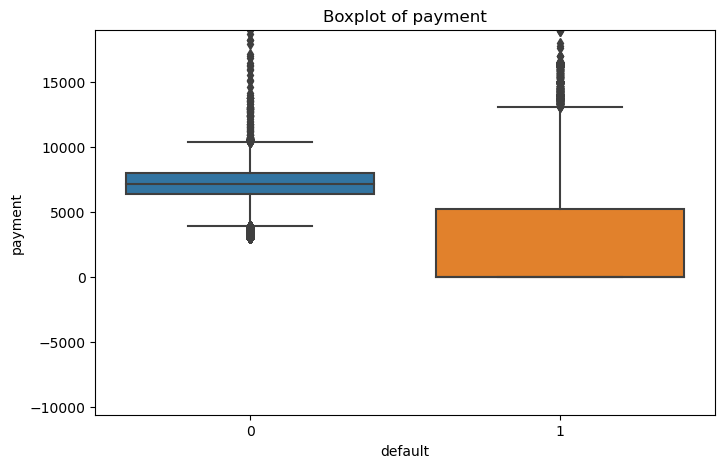

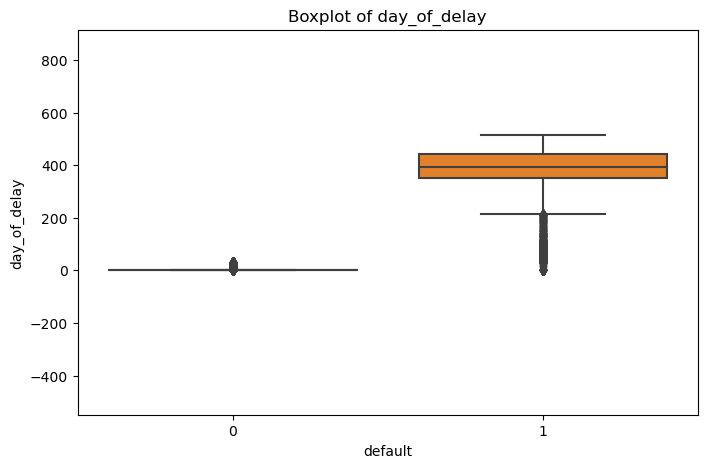

In [65]:
plot_boxplot_upgrade(df, numeric, 'default')

- на суммах меньше 6 т.р. рублей дефолтятся чаще относительно сумм 6-8т.р.
- в графе ежемесячного дохода у недефолтников межквартильных размах и медианное значение соответственно больше.
- запрашивают на займ чаще всего 6-8 т.р. на 1 месте и 2-6 т.р. на 2 месте
- в данном датасете примерно получают такой же займ, как и запрашивают
- большая часть брала займ сроком на 30 дней
- задолженность у нас имеют дефолтники 15-22 т.р. в большинстве случаев
- сумма всех платежей у дефолтников составляет 0-5к рублей межквартильный размах и где-то 6-7к рублей для недефолтников. Так же среди дефолтников есть и те, кто выплатил уже больше 50к рублей
- среди займов на короткое время дефолтников значенительно меньше в отличии от тех, кто брал на 30 дней
- среди дефолтников межквартильный размах находится вокруг 400 дней просрочки
- клиенты со средне специальным и средним образованием дефолтятся чаще, чем клиенты с высшим
- модель 59 работает лучше всех, но она обработала меньше всех клиентов, на 2м месте модель 54
- ТЭК, айти и финансы / банки / консалтинг - самые надежные виды деятельности
- самые надежные цели займа - путешествия и образование
- медсестра/медбрат, начальник / руководитель, продавец - дефолтятся реже других, рабочий дефолтится чаще всех

#### Выдвинем гипотезу

**По нашему исследованию и графикам можно сказать, что у категории дефолта ежемесячный доход меньше чем у категории людей недефолтников. Проверим это, тогда:**

H0: ежемесячный доход у двух наших категорий клиентов равна

H1: ежемесячный доход у двух наших категорий клиентов равна различен

In [66]:
alpha = 0.05

default_0 = df[df['default']==1]['monthly_income']
default_1 = df[df['default']==0]['monthly_income']

results = st.ttest_ind(default_0, default_1, equal_var=False)


print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.986711574418764e-52
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Стоило бы принять Н1, но:  
Наш тест может быть не очень точным так как для ти-теста стьюдента требуется нормальное распределение.  
Проверим наш столбец на нормальность распределенеия тестом Шапиро-Уилка

In [67]:
stat, p = shapiro(df['monthly_income'])

# Выводим результаты теста
print('Статистика теста:', stat)
print('p-значение:', p)

# Проверяем гипотезу о нормальности распределения
if p > alpha:
    print('p-значение больше уровня значимости, нет оснований отвергнуть гипотезу о нормальности распределения.')
else:
    print('p-значение меньше уровня значимости, отвергаем гипотезу о нормальности распределения.')

Статистика теста: 0.5209890604019165
p-значение: 0.0
p-значение меньше уровня значимости, отвергаем гипотезу о нормальности распределения.


Таким образом сделаем еще одну проверку гипотезы с помощью теста Уилкоксона-Манна-Уитни

In [68]:
stat, p = mannwhitneyu(default_0, default_1, alternative='two-sided')

print('p-значение:', p)
if p < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.8970725556021162e-98
Отвергаем нулевую гипотезу


**Нулевая гипотеза отвергнута. Принимаем гипотезу H1.**

### Посмотрим на корреляции между признаками

**тепловая карта числовых признаков**

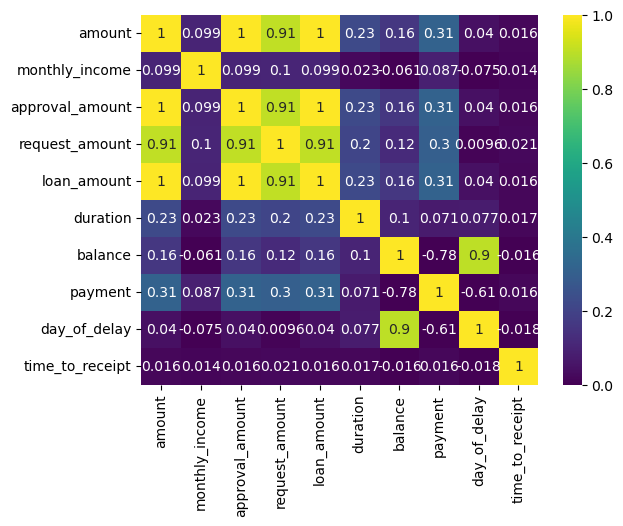

In [69]:
sns.heatmap(df.corr(), cmap='viridis', annot=True, vmin=0);

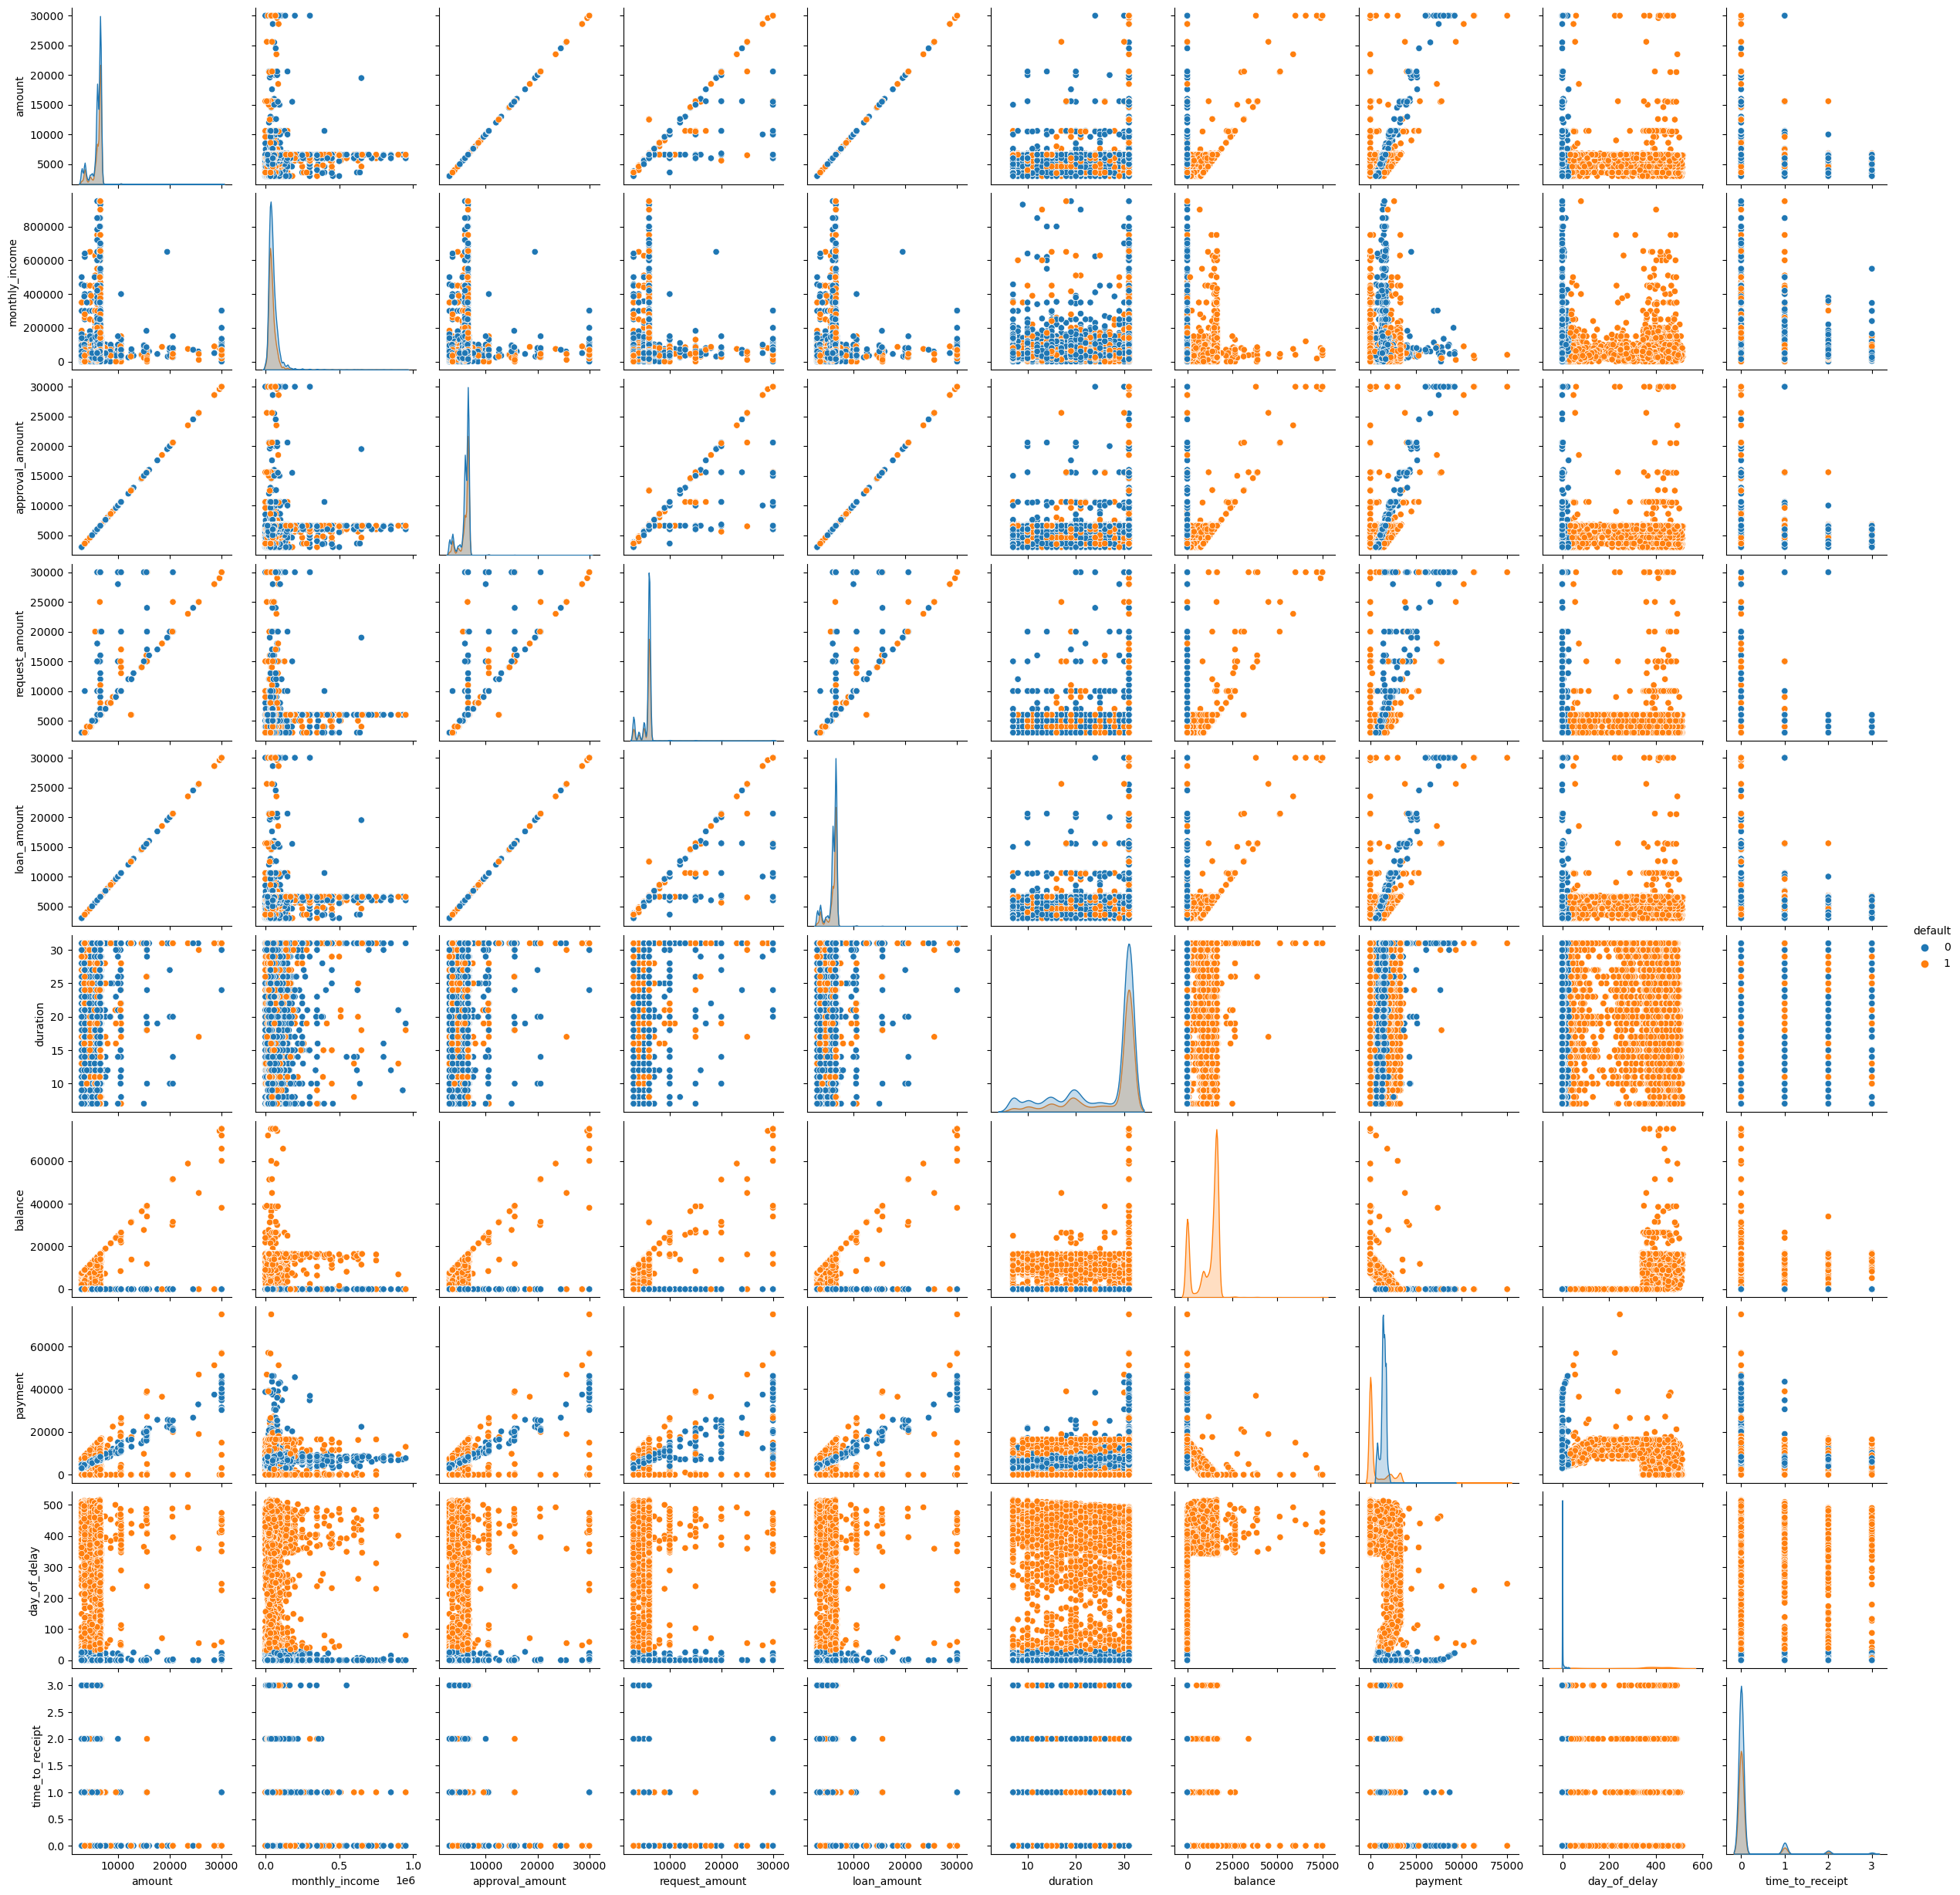

In [70]:
# построим паирплот дополнительно для проверки корреляций

sns.pairplot(df, hue='default');

График не очень читабелен, но очень важен для понимания (хорошо, что у меня большой экран:)

Среди числовых столбцов у нас есть высокие корреляции. Учтем это при подготовке датасета для обучения.

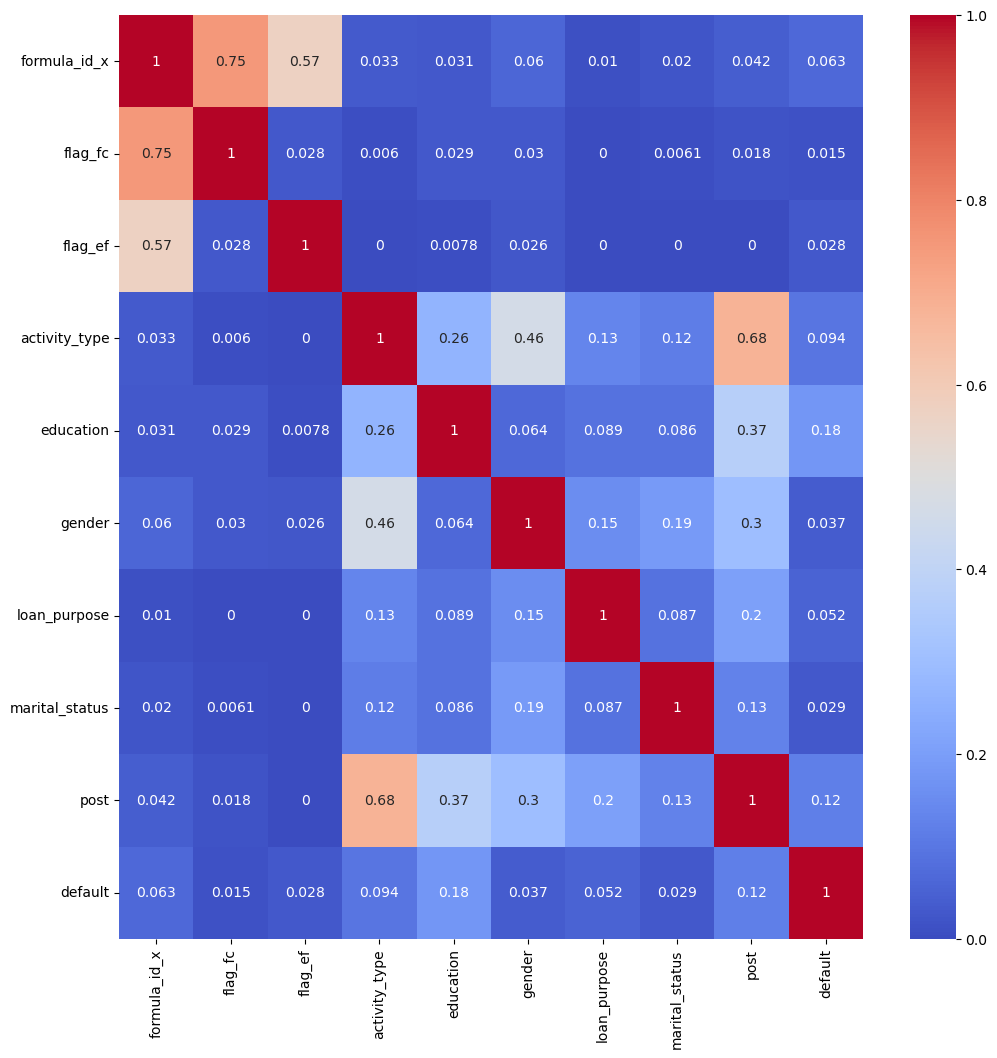

In [71]:
corr_matrix = phik_matrix(df[cat])


fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, ax=ax)
plt.show()

Высоких корреляций нет

### Найдём сегмент клиентов, у которых дефолтность менее 25%

Выделим в отдельный сегмент клиентов с ежемесячным доходом от 90 т.р. и с высшим образованием

In [72]:
default_25 = df.loc[(df["monthly_income"] >= 90000) & (df["education"] == 'высшее')] 

In [73]:
ratio_def = default_25[default_25['default']==1]['default'].count() / default_25.shape[0] * 100
print(f'Дефолтность сегмента равна: {ratio_def:.2f}%')
print('Кол-во людей в сегменте:', default_25.shape[0])

Дефолтность сегмента равна: 23.21%
Кол-во людей в сегменте: 2072


### Построим таблицу по выделенному сегменту, в которой будут отображены дефолтность и доходность по каждой неделе

Построим таблицу, которая будет содержать айди клиента, суммы выплаченные между определенными промежутками дней (в основном каждые 15 дней), сумма всех выплат и дефолтность.

In [74]:
default_25_tabl = payments[
            ['draft_id', 'amount_00', 'amount_15', 'amount_30', 'amount_45', 'amount_60', 'amount_90', 'amount_91']
        ].merge(default_25[['draft_id', 'payment', 'default']], on='draft_id')

In [75]:
default_25_tabl.head(7)

draft_id  amount_00  amount_15  amount_30  \
0  6ace9e4e-5100-46c8-9d3b-11b5d43bf548        NaN   3,108.00        NaN   
1  4269b2b9-ea01-4aad-8c7e-f7d3e31f9a8c   6,565.00        NaN        NaN   
2  7b473e55-a9f4-4362-b751-707c4781e21a   6,300.00        NaN        NaN   
3  57105799-4a76-41ee-ab6c-da319cab63dd   7,326.00        NaN        NaN   
4  9cc9b41c-c6a9-4837-95e0-b46e86b4fc7e   6,180.00        NaN        NaN   
5  8b7fd7d8-006e-4bc1-9df4-37de6494dab9   6,240.00        NaN        NaN   
6  f2376d49-8329-4d02-b3c2-6a8bb4a17ef0   7,020.00        NaN        NaN   

   amount_45  amount_60  amount_90  amount_91  payment default  
0        NaN        NaN        NaN        NaN 3,108.00       1  
1        NaN        NaN        NaN        NaN 6,565.00       0  
2        NaN        NaN        NaN        NaN 6,300.00       0  
3        NaN        NaN        NaN        NaN 7,326.00       0  
4        NaN        NaN        NaN        NaN 6,180.00       0  
5        NaN        NaN        NaN        NaN 6,240.00       0  
6        NaN        NaN        NaN        NaN 7,020.00       0

In [76]:
# сохранение в Excel файл

default_25_tabl.to_excel('default_25_tabl.xlsx', index=False)

Пометка: не знаю, правильно ли я понял выделение доходности по каждой неделе. Или же надо было взять сумму всех выплат и разделить равными частями на каждый день и внести в таблицу понедельно.  
**На всякий случай сделаю второй вариант.**

In [77]:
# максимальное и минимальное кол-во дней

default_25['duration'].max(), default_25['duration'].min()

(31.0, 7.0)

Максимально 31 день, значит, будем использовать 5 недель

In [78]:
# создадим столбем с доходом за 1 день

default_25['per_day'] = default_25['payment'] / default_25['duration']

In [79]:
# разбиение записей на недели

week1 = default_25['duration'].apply(lambda x: min(x, 7))
week2 = default_25['duration'].apply(lambda x: min(max(x - 7, 0), 7))
week3 = default_25['duration'].apply(lambda x: min(max(x - 14, 0), 7))
week4 = default_25['duration'].apply(lambda x: min(max(x - 21, 0), 7))
week5 = default_25['duration'] - week1 - week2 - week3 - week4

# рассчет доходности за каждую неделю

default_25['week_1'] = default_25['per_day'] * week1
default_25['week_2'] = default_25['per_day'] * week2
default_25['week_3'] = default_25['per_day'] * week3
default_25['week_4'] = default_25['per_day'] * week4
default_25['week_5'] = default_25['per_day'] * week5

In [80]:
# Создадим таблицу с интересующими нас столбцами

default_25_tabl_2 = default_25[['draft_id', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'default']]

In [81]:
default_25_tabl_2.head(7)

draft_id   week_1   week_2   week_3   week_4  \
42   6ace9e4e-5100-46c8-9d3b-11b5d43bf548   870.24   870.24   870.24   497.28   
57   4269b2b9-ea01-4aad-8c7e-f7d3e31f9a8c 1,482.42 1,482.42 1,482.42 1,482.42   
58   7b473e55-a9f4-4362-b751-707c4781e21a 1,696.15 1,696.15 1,696.15 1,211.54   
62   57105799-4a76-41ee-ab6c-da319cab63dd 1,654.26 1,654.26 1,654.26 1,654.26   
101  9cc9b41c-c6a9-4837-95e0-b46e86b4fc7e 1,395.48 1,395.48 1,395.48 1,395.48   
111  8b7fd7d8-006e-4bc1-9df4-37de6494dab9 1,409.03 1,409.03 1,409.03 1,409.03   
121  f2376d49-8329-4d02-b3c2-6a8bb4a17ef0 2,890.59 2,890.59 1,238.82     0.00   

     week_5 default  
42     0.00       1  
57   635.32       0  
58     0.00       0  
62   708.97       0  
101  598.06       0  
111  603.87       0  
121    0.00       0

In [82]:
# сохранение в Excel файл

default_25_tabl_2.to_excel('default_25_tabl_2.xlsx', index=False)

**Минивывод:**  
Был проведен исследовательский анализ данных, по которому были сделаны определенные выводы:  
- на суммах меньше 6 т.р. рублей дефолтятся чаще относительно сумм 6-8т.р.
- в графе ежемесячного дохода у недефолтников межквартильных размах и медианное значение соответственно больше.
- запрашивают на займ чаще всего 6-8 т.р. на 1 месте и 2-6 т.р. на 2 месте
- в данном датасете примерно получают такой же займ, как и запрашивают
- большая часть брала займ сроком на 30 дней
- задолженность у нас имеют дефолтники 15-22 т.р. в большинстве случаев
- сумма всех платежей у дефолтников составляет 0-5к рублей межквартильный размах и где-то 6-7к рублей для недефолтников. Так же среди дефолтников есть и те, кто выплатил уже больше 50к рублей
- среди займов на короткое время дефолтников значенительно меньше в отличии от тех, кто брал на 30 дней
- среди дефолтников межквартильный размах находится вокруг 400 дней просрочки
- клиенты со средне специальным и средним образованием дефолтятся чаще, чем клиенты с высшим
- модель 59 работает лучше всех, но она обработала меньше всех клиентов, на 2м месте модель 54
- ТЭК, айти и финансы / банки / консалтинг - самые надежные виды деятельности
- самые надежные цели займа - путешествия и образование
- медсестра/медбрат, начальник / руководитель, продавец - дефолтятся реже других, рабочий дефолтится чаще всех  

Были сделаны хитмэпы корреляций между числовыми столбцами и катериальными. В числовых столбцах были обнаружены высокие корреляции, которые могут негативно сказаться в обучении модели.

**Были выполнены поставленные задачи по выделению сегмента с дефолтностью менее 25% и была сделана соответствующая таблица.**

## Построение модели

**Разобьём датасет на фичи и таргеты**

In [83]:
df_new = df.copy() # копию создал на случай того, если надо будет обратиться отдельно к дф

In [84]:
# Добавим датасет с поведенческими данными по клиенту ml

df_new = pd.merge(df_new, ml, on='draft_id', how='inner')

In [85]:
X = df_new.drop([
                'draft_id', 'default', 'day_of_delay', 
                'balance', 'payment', 'loan_amount', 
                'amount', 'time_to_receipt', 'approval_amount'
        ], axis=1)

y = df_new['default']

Пришлось удалить почти все столбцы датасета payments, так как это было бы утечкой данных из будущего, но оставили из него запрашиваемую сумму клиентом и срок погашения займа, так как эта информация доступна перед одобрением. Из датасета anket удалили столбец с полом.

**Разделим фичи и таргеты на тренировочные и тестовые в пропорции 4 к 1**

In [86]:
# полные фичи и таргеты
X, X_test, y, y_test = train_test_split(
                                    X, y, test_size=0.2, random_state=random_state, stratify=y
)

In [87]:
# проверка кол-ва строк и столбцов
X.shape, X_test.shape, y.shape, y_test.shape

((33080, 82), (8271, 82), (33080,), (8271,))

**Кодировщики**

In [88]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ss = StandardScaler()

### Создадим словари перебираемых параметров будущих моделей и ансамблей

In [89]:
tree_params = {
    'decisiontreeclassifier__class_weight' : ['balanced', None],
    'decisiontreeclassifier__max_depth': range(1, 15)
}

forest_params = {
    'randomforestclassifier__class_weight' : ['balanced', None],
    'randomforestclassifier__n_estimators' : range(100, 400, 50), 
    'randomforestclassifier__max_depth' : range(5, 15, 3),
    'randomforestclassifier__min_samples_split' : (2, 3, 4),
    'randomforestclassifier__min_samples_leaf' : (1, 2, 3, 4)
}

regressor_params = {
    'logisticregression__class_weight' : ['balanced', None],
    'logisticregression__class_weight': ['balanced', None],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.1, 1.0, 10.0],
    'logisticregression__solver': ['liblinear', 'saga']
}

lgbm_params = {
    'class_weight' : ['balanced', None],
    'boosting_type': ['gbdt', 'dart', 'goss'], 
    'importance_type': ['split', 'gain'], 
    'learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
    'max_depth': [-1, 3, 5, 6], 
    'n_estimators': [50, 100, 150, 500, 1000], 
    'subsample_for_bin': [200000, 50000, 100000]
}

xgboost_params = {
    'gradientboostingclassifier__max_depth' : range(10, 16 , 5), 
    'gradientboostingclassifier__learning_rate' : [0.1, 0,3, 0.01],
    'gradientboostingclassifier__n_estimators' : range(100, 400, 50)
}

cbr_params ={
             'auto_class_weights' : ['Balanced', None],
             'iterations' : [500], 
             'depth': [3, 5, 7, 10], 
             'learning_rate': [.1, .01, .5], 
             'l2_leaf_reg': [1, 3, 5, 10], 
             'loss_function': ['Logloss', 'CrossEntropy']
} 

### Напишем функцию джини и рандомсерча

In [90]:
def gini_score(y_true: List[int], y_pred: List[float]) -> float:
    """
    Вычисляет значение метрики Gini для задачи бинарной классификации
    """
    return 2 * roc_auc_score(y_true, y_pred) - 1

def randomiz_search(model: Any, params: Dict[str, Any], num_iter: int, cv: int, X: Any, y: Any) -> Any:
    """Функция обучит модель с помощью RandomizedSearchCV
    и вернёт модель, обученную на лучших гиперпараметрах
    с самой высокой метрикой Gini, а также
    напечатает значения метрики Gini"""
    
    gini_scorer = make_scorer(gini_score, greater_is_better=True, needs_proba=True)
    
    model = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=num_iter,
        verbose=200,
        scoring=gini_scorer,
        cv=cv,
        n_jobs=-1,
        refit=True,
        random_state=random_state
    )
    model.fit(X=X, y=y)
    
    # выведем метрику Gini на экран
    print("Gini score:", round(model.best_score_, 4))
    
    return model

### Препроцессинг для пайплайна

In [91]:
# создадим списки для числовых значений
numeric = list(X.select_dtypes(include=['int64', 'float64']).columns)
cat = list(X.select_dtypes(include=['category']).columns)

col_transformer_ohe = make_column_transformer(
    (ohe, cat),
    (ss, numeric),
    remainder='passthrough'
)

col_transformer_enc = make_column_transformer(
    (enc, cat),
    (ss, numeric),
    remainder='passthrough'
)

### Пайплайн для линейной регрессии, случайного леса, дерева решений и XGBoost

**Пайплайны для полного датасета**

In [92]:
# логистическая регрессия
pipeline_linear = make_pipeline(
    col_transformer_ohe, LogisticRegression(random_state=random_state)
)

# случайный лес
pipeline_forest = make_pipeline(
    col_transformer_enc, RandomForestClassifier(random_state=random_state)
)

# дерево решений
pipeline_tree = make_pipeline(
    col_transformer_enc, DecisionTreeClassifier(random_state=random_state)
)

# XGBoost  
pipeline_xgboost = make_pipeline(
    col_transformer_enc, GradientBoostingClassifier(random_state=random_state)
)

### Пайплайн для решающего дерева с рандомсерчем¶

In [93]:
tree = randomiz_search(pipeline_tree, tree_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gini score: 0.286


### Пайплайн для логистической регрессии с рандомсерчем

In [94]:
regression = randomiz_search(pipeline_linear, regressor_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gini score: 0.3437


### Пайплайн для случайного леса с рандомсерчем

In [95]:
forest = randomiz_search(pipeline_forest, forest_params, 10, 5, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gini score: 0.3606


### LGBMClassifier

In [96]:
model_lgbm = randomiz_search(
    LGBMClassifier(
                random_state = random_state
                 ), 
    lgbm_params, 15, 8, X, y
    )

Fitting 8 folds for each of 15 candidates, totalling 120 fits
Gini score: 0.3868


### XGBoost

In [97]:
# model_xgboost = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5, X, y)

```python
model_xgboost = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5, X, y)
```
Fitting 5 folds for each of 10 candidates, totalling 50 fits  
Gini score: 0.3443

*Оооочень долго считает, поэтому оставлю результат так*

### CatBoostClassifier

In [98]:
model_cbc = randomiz_search(
    CatBoostClassifier(
        auto_class_weights='Balanced',
        cat_features=cat,
        random_seed = random_state
            ), 
    cbr_params, 10, 5, X, y
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6852946	total: 286ms	remaining: 2m 22s
1:	learn: 0.6795698	total: 370ms	remaining: 1m 32s
2:	learn: 0.6743107	total: 444ms	remaining: 1m 13s
3:	learn: 0.6700951	total: 518ms	remaining: 1m 4s
4:	learn: 0.6665114	total: 598ms	remaining: 59.2s
5:	learn: 0.6636455	total: 672ms	remaining: 55.3s
6:	learn: 0.6607949	total: 747ms	remaining: 52.6s
7:	learn: 0.6579074	total: 836ms	remaining: 51.4s
8:	learn: 0.6552583	total: 913ms	remaining: 49.8s
9:	learn: 0.6527668	total: 989ms	remaining: 48.4s
10:	learn: 0.6505036	total: 1.06s	remaining: 47.2s
11:	learn: 0.6490165	total: 1.15s	remaining: 46.7s
12:	learn: 0.6473166	total: 1.22s	remaining: 45.9s
13:	learn: 0.6454466	total: 1.3s	remaining: 45.2s
14:	learn: 0.6437715	total: 1.39s	remaining: 44.9s
15:	learn: 0.6424977	total: 1.46s	remaining: 44s
16:	learn: 0.6412175	total: 1.52s	remaining: 43.3s
17:	learn: 0.6400502	total: 1.6s	remaining: 42.8s
18:	learn: 0.6390613	total: 1.67

**Лучшей моделью у нас оказался лайтбустинг. Значит, можно поиграться со столбцами и попробовать улучшить метрику еще больше**

### Построим график важности признаков

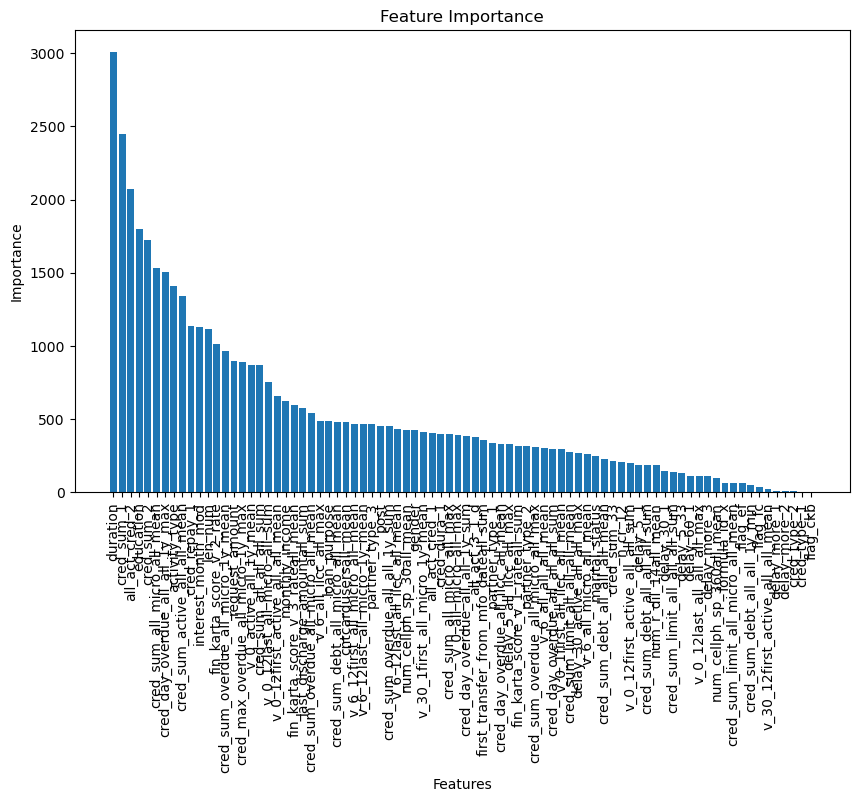

In [99]:
feature_importance = model_lgbm.best_estimator_.feature_importances_
feature_names = X.columns

# создадим датафрейм с важностью функций
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# отсортируем значения по важности в порядке убывания
feature_importance_df.sort_values('importance', ascending=False, inplace=True)

# построим столбчатую диаграмму важности функций
plt.figure(figsize=(10, 6))
plt.bar(x=feature_importance_df['feature'], height=feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [100]:
# Взглянем на датафрейм важности фичей

feature_importance_df

feature  importance
12                             duration    3,007.79
32                           cred_sum_1    2,445.30
24                       all_act_cred_2    2,075.00
5                             education    1,799.67
33                           cred_sum_2    1,726.63
38          cred_sum_all_micro_all_mean    1,534.59
25      cred_day_overdue_all_all_1y_max    1,503.77
4                         activity_type    1,408.21
35         cred_sum_active_all_all_mean    1,340.77
31                         cred_repay_1    1,136.38
61                   interest_month_mod    1,129.15
62                              len_num    1,112.03
16             fin_karta_score_v_2_rate    1,012.54
47   cred_sum_overdue_all_micro_1y_mean      963.97
11                       request_amount      895.80
30    cred_max_overdue_all_micro_1y_max      890.58
72               v_0_active_all_1y_mean      870.69
36             cred_sum_all_all_all_sum      867.03
70         v_0_12last_all_micro_all_sum      755.62
67      v_0_12first_active_all_all_mean      655.17
9                        monthly_income      625.05
14     fin_karta_score_v_3_rateall_mean      596.97
18         last_discharge_amountall_sum      573.05
49  cred_sum_overdue_all_micro_all_mean      540.24
80                 v_6_all_ilcc_all_max      486.40
7                          loan_purpose      484.50
42     cred_sum_debt_all_micro_all_mean      482.27
13                 cntcardusersall_mean      480.80
76       v_6_12first_all_micro_all_mean      467.40
78         v_6_12last_all_micro_1y_mean      465.28
66                       partner_type_3      463.24
10                                 post      454.35
46      cred_sum_overdue_all_all_1y_sum      448.81
77         v_6_12last_all_ilcc_all_mean      433.78
19             num_cellph_sp_30all_mean      427.05
6                                gender      426.45
75        v_30_1first_all_micro_1y_mean      411.11
23                       all_act_cred_1      401.30
29                          cred_dura_1      396.14
37           cred_sum_all_micro_all_max      394.85
73                v_0_all_micro_all_max      390.52
26      cred_day_overdue_all_all_1y_sum      384.62
22                        all_act_3_1_d      373.33
17  first_transfer_from_mfo_dateall_sum      355.44
64                       partner_type_1      335.04
28   cred_day_overdue_all_ilcc_all_mean      326.47
59             delay_5_all_ilcc_all_max      325.48
15      fin_karta_score_v_1_rateall_sum      315.27
65                       partner_type_2      312.67
48   cred_sum_overdue_all_micro_all_max      306.94
79                 v_6_all_all_all_mean      298.60
27     cred_day_overdue_all_all_all_sum      293.93
71         v_0_1first_all_ilcc_all_mean      292.68
43      cred_sum_limit_all_all_all_mean      271.25
56          delay_30_active_all_all_max      269.37
81               v_6_all_micro_all_mean      258.81
8                        marital_status      246.84
40       cred_sum_debt_all_all_all_mean      227.54
34                          cred_sum_33      210.86
63                              n_cr_12      209.02
68       v_0_12first_active_all_all_sum      199.44
57                            delay_5_1      185.62
41        cred_sum_debt_all_all_all_sum      185.30
21                 num_r_dil_14all_mean      182.94
55                           delay_30_1      147.23
44       cred_sum_limit_all_all_all_sum      139.57
58                           delay_5_33      129.93
60                           delay_60_1      112.08
69           v_0_12last_all_all_all_max      108.52
54                         delay_more_3      107.67
20            num_cellph_sp_360all_mean       98.89
0                          formula_id_x       64.74
45    cred_sum_limit_all_micro_all_mean       63.91
2                               flag_ef       59.70
39         cred_sum_debt_all_all_1y_min       49.06
1                               flag_fc       34.18
74     v_30_12first_active_a

In [101]:
# Важными фичами по итогу было принято решение оставить важность больше 200

importance_list = feature_importance_df.loc[feature_importance_df['importance'] > 200]['feature'].tolist()

In [102]:
# Обновим тренировочную выборку для lgbm

X_upgrade = X[importance_list]
X_upgrade.shape, X.shape

((33080, 60), (33080, 82))

In [103]:
# Обучим заново модель на обрезанных фичах

model_lgbm = randomiz_search(
    LGBMClassifier(
                random_state = random_state
                 ), 
    lgbm_params, 15, 8, X_upgrade, y
    )

Fitting 8 folds for each of 15 candidates, totalling 120 fits
Gini score: 0.3848


Качество не сильно изменилось, но время солидно сократилось

In [104]:
# Выведем лучшие параметры

model_lgbm.best_params_

{'subsample_for_bin': 100000,
 'n_estimators': 150,
 'max_depth': -1,
 'learning_rate': 0.1,
 'importance_type': 'gain',
 'class_weight': None,
 'boosting_type': 'dart'}

In [105]:
# Обновимс сетку гиперпараметров

lgbm_params = {
    'class_weight' : [None],
    'boosting_type': ['dart'], 
    'importance_type': ['gain'], 
    'learning_rate': [0.1, 0.09, 0.08, 0.12, 0.14], 
    'max_depth': [-1, 1, 2, -2], 
    'n_estimators': range(130, 170, 5), 
    'subsample_for_bin': [100000]
}

In [106]:
# Обучим заново модель на новой сетке

model_lgbm = randomiz_search(
    LGBMClassifier(
                random_state = random_state
                 ), 
    lgbm_params, 15, 8, X_upgrade, y
    )

Fitting 8 folds for each of 15 candidates, totalling 120 fits
Gini score: 0.3852


In [107]:
# Новые лучшие параметры
model_lgbm.best_params_

{'subsample_for_bin': 100000,
 'n_estimators': 160,
 'max_depth': -1,
 'learning_rate': 0.08,
 'importance_type': 'gain',
 'class_weight': None,
 'boosting_type': 'dart'}

In [108]:
# сделать предсказания на тестовых данных
y_pred_proba = model_lgbm.predict_proba(X_test[X_upgrade.columns])[:, 1]
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# вывести метрику Gini и ROC-AUC
gini = gini_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Gini score:", gini)
print("ROC-AUC score:", roc_auc)

Gini score: 0.3801593727635997
ROC-AUC score: 0.6900796863817998


### Построим график ROC-AUC

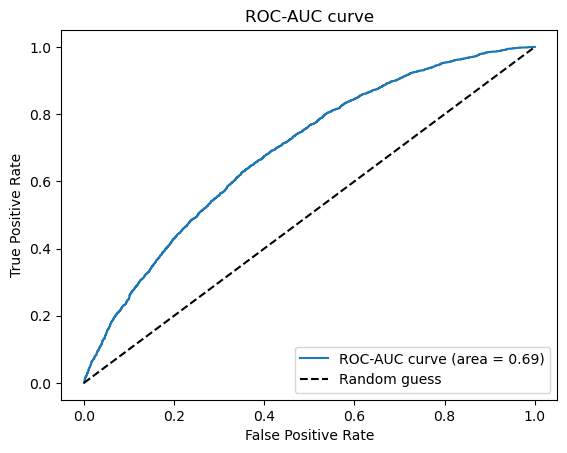

In [109]:
# Считаем значения FPR и TPR для разных пороговых значений
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Строим ROC-AUC кривую
plt.plot(fpr, tpr, label='ROC-AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc='lower right')
plt.show()

**Площадь рок-кривой и метрика джини говорит об умеренно хорошем качестве нашей модели**

### Матрица ошибок

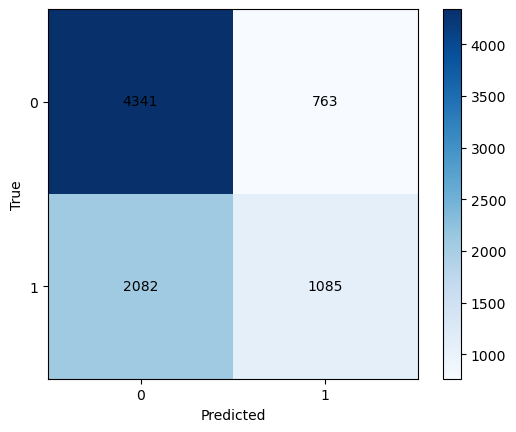

In [110]:
# создаем матрицу ошибок
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_binary)

# визуализируем матрицу ошибок с точными цифрами
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center')
plt.show()

Ошибка первого рода в контексте прогнозирования дефолта означает, что модель неправильно предсказывает, что клиент не дефолтнется, когда на самом деле он дефолтнется. То есть, модель даёт ложно положительный результат.  
В этом случае банк предоставляет кредит клиенту, который впоследствии не сможет его вернуть, что приведёт к убыткам для банка. Это нежелательный и рискованный исход, который банк старается минимизировать.

Ошибка второго рода в контексте прогнозирования банкротства означает, что модель неправильно предсказывает, что клиент дефолтнется, когда на самом деле он не дефолтнется. То есть, модель даёт ложно отрицательный результат.
В этом случае банк отказывается предоставлять кредит клиенту, который в действительности мог бы вернуть его успешно, что приведёт к потере потенциального дохода от процентов по кредиту. Это также нежелательный исход, но он не такой для нас критичный, поэтому мною рекомендовано оценивать модель по метрике precision.

## Вывод

**В разведывательном анализе данных:**  

    В датасете anket:  
        1. столбцы были приведены в змеиный регистр  
        2. в пропусках с категориальными значениями заменили пропуски на нули  
        3. поработали с неявными дублями и объединили некоторые категории  
        4. построили графики, чтобы посмотреть распределения:    
            - чаще всего используется модель для анализа под номером 55  
            - флаг наличия ответа от партнёра "один" и "два" почти всегда 1, а партнёра "три" - всегда 0  
            - займы берут по большей части из-за непредвиденных трат и подарков  
            - большая часть имеет высшее образование или хотя бы среднее специальное  
            - большая часть заемщиков с их же слов является категорией руководства  
        
    В датасете payments:
        1. убрали клиентов, кому было отказано в займе
        2. убрали клиентов, кто по своей воле не взял займ после одобрения
        3. определили природу оставшихся пропусков
        4. поработали с выбросами
        5. убрали лишние столбцы
        6. построили графики и посмотрели распределения
    
    В датасете ml:
        1. было решено бороться с пропусками удалением столбцов там, где пропусков больше 30%
        2. столбцы с высокой корреляцией так же были удалены
        3. столбцы, включающие в себя 90 дней и 180 дней были удалены как неинформативные в нашем случае
        4. оставшиеся пропуски были заполнены методом ffill

**Был проведен исследовательский анализ данных, по которому были сделаны определенные выводы:**  

    - на суммах меньше 6 т.р. рублей дефолтятся чаще относительно сумм 6-8т.р.  
    - в графе ежемесячного дохода у недефолтников межквартильных размах и медианное значение соответственно больше.  
    - запрашивают на займ чаще всего 6-8 т.р. на 1 месте и 2-6 т.р. на 2 месте  
    - в данном датасете примерно получают такой же займ, как и запрашивают  
    - большая часть брала займ сроком на 30 дней  
    - задолженность у нас имеют дефолтники 15-22 т.р. в большинстве случаев  
    - сумма всех платежей у дефолтников составляет 0-5к рублей межквартильный размах и где-то 6-7к рублей для недефолтников. Так же среди дефолтников есть и те, кто выплатил уже больше 50к рублей  
    - среди займов на короткое время дефолтников значенительно меньше в отличии от тех, кто брал на 30 дней  
    - среди дефолтников межквартильный размах находится вокруг 400 дней просрочки  
    - клиенты со средне специальным и средним образованием дефолтятся чаще, чем клиенты с высшим  
    - модель 59 работает лучше всех, но она обработала меньше всех клиентов, на 2м месте модель 54  
    - ТЭК, айти и финансы / банки / консалтинг - самые надежные виды деятельности  
    - самые надежные цели займа - путешествия и образование  
    - медсестра/медбрат, начальник / руководитель, продавец - дефолтятся реже других, рабочий дефолтится чаще всех  

*Были сделаны хитмэпы корреляций между числовыми столбцами и катериальными. В числовых столбцах были обнаружены высокие корреляции, которые могли негативно сказаться в обучении модели.*  

**Были выполнены поставленные задачи по выделению сегмента с дефолтностью менее 25% и была сделана соответствующая таблица.**

Мы подготовили наши фичи и таргеты полным датасетом и с отбросом корреляций.  
Отрезали тестовую выборку, построили пайплайны и начали обучение на моделях: деревьев, логрега; ансамблях: бэггиновый ансамбль - случайный лес и бустинговые ансамбли - лайтбуст, катбуст и XGBoost.  
Лучше всех показал себя лайтбуст. Поэтому были принято решение поработать со столбцами для улучшения метрики.    
Построили график важности фичей.   
С ним начали работать и пробовать отсекать разные значения важности, но остановились на фичах выше 200  
Далее вытащили лучшие гиперпараметры и обновили около них, чтобы сделать метрику еще точнее
Затем сделали предикты на тесте, посчитали джини и рок-аук.   
Визуализировали рок-кривую и построили матрицу ошибок, чтобы визуализировать полученные результаты.   
Дали определение ошибке первого рода и ошибке второго рода  
*Результаты можно оценить как умеренно хорошие*

**Рекомендации:**  

1. Обратить внимание на модель 53! Её предсказания ужасные. Кол-во дефолтников больше кол-ва нормальных клиентов
2. Клиенты, имеющие неполное среднее дефолтятся с вероятностью 91%. Обратить внимание
3. Клиенты, с местом работы "рабочий" дефолтятся с вероятностью 81%. Обратить внимание
4. Рекомендуется оценивать рабочую модель метрикой precision, так как ошибки первого рода для компании скорее всего намного убыточнее

PS Зная лучше описание столбцов и имея больше времени, можно было бы улучшить метрику. Здесь я просто хотел показать ход мышления